In [123]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os
#
import ast
import sys
#
from sklearn.impute import KNNImputer
import catboost
#
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
#
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
#
import shap
#
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
##from sklearn.ensemble import CatBoostRegressor  # или твоя модель
from sklearn.model_selection import RandomizedSearchCV
#
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
#
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
#
from flask import Flask, request, jsonify
#
import requests
import joblib
#





In [124]:
# Читаем данные
df = pd.read_csv('data/data.csv')
##display(df)

In [125]:
df = df.drop_duplicates()
print("Осталось дубликатов:", df.duplicated().sum())



Осталось дубликатов: 0


Делаем предаброботку некоторых признаков, извлекая оттуда нужные числовые значения и приводя к численному виду

In [126]:
df['beds'] = pd.to_numeric(df['beds'].str.extract(r'(\d+)')[0], errors='coerce')
df['baths'] = pd.to_numeric(df['baths'].str.extract(r'(\d+\.?\d*)')[0], errors='coerce')
df['sqft'] = pd.to_numeric(df['sqft'].str.replace(',', '').str.extract(r'(\d+\.?\d*)')[0], errors='coerce')
df['target'] = pd.to_numeric(df['target'].str.replace(r'[\$,]', '', regex=True), errors='coerce')


In [127]:
# делаем замену жаргонных выражений на стандартные понятия
#
df['propertyType'] = df['propertyType'].str.lower().str.strip()
df['propertyType'] = np.where(
    df['propertyType'].isin(['mobile', 'prefab', 'modular']),
    'manufactured home (house)',
    df['propertyType']
)
df['propertyType'] = df['propertyType'].str.lower().str.strip()
df['propertyType'] = np.where(
    df['propertyType'].isin(['mo2 le', 'mo2le']),
    'mobile',
    df['propertyType']
)
#
df['propertyType'] = df['propertyType'].str.lower().str.strip()
df['propertyType'] = np.where(
    df['propertyType'].isin(['ca2 n', 'ca2n']),
    'cabin',
    df['propertyType']
)
#
df['propertyType'] = df['propertyType'].str.lower().str.strip()
df['propertyType'] = np.where(
    df['propertyType'].isin(['mid century', 'mid-century']),
    'midcentury',
    df['propertyType']
)
#
df['propertyType'] = df['propertyType'].str.lower().str.strip()
df['propertyType'] = np.where(
    df['propertyType'].isin(['single-family home', 'single family', 'single family home']),
    'single family',
    df['propertyType']
)

### новый признак '**has_pool**'

объединяем в один признак бассейны

In [128]:
#
df['has_pool'] = df[['private pool', 'PrivatePool']].apply(
    lambda row: (
        True if any(str(x).strip().lower() in ['yes', 'Yes'] for x in row if pd.notnull(x))
        else 'not inform'
    ),
    axis=1
)


In [129]:
#
display(df['has_pool'].unique())
display(df['has_pool'].value_counts(dropna=False))

array(['not inform', True], dtype=object)

has_pool
not inform    332644
True           44491
Name: count, dtype: int64

предполагаем, что частные большие дома должны иметь бассейны. Поэтому, чтобы дополнить количество строк с бассейнами делаем :

In [130]:
likely_pool_types = ['single family', 'house', 'villa', 'detached']
#
df['has_pool'] = df.apply(
    lambda row: True if (
        row['has_pool'] == 'not inform' and
        str(row['propertyType']).strip().lower() in likely_pool_types and
        pd.to_numeric(row['sqft'], errors='coerce') > 2500
    ) else row['has_pool'],
    axis=1
)

In [131]:
#
# сразу кодируем
df['has_pool'] = df['has_pool'].apply(lambda x: 1 if x is True else 0)
#
df['has_pool'].value_counts(dropna=False).to_csv('csv/has_pool.csv')
display(df['has_pool'].value_counts(dropna=False))

has_pool
0    287159
1     89976
Name: count, dtype: int64

удаляем mls-id, так как почти все пропуски   

MlsId -огромное количество уникальных, тоже удаляем   
Удаляем 'PrivatePool', 'private pool', так как сильно разреженный.

In [132]:
# удаляем mls-id, так как почти все пропуски
#  MlsId -огромное количество уникальных, тоже удаляем
print(df['MlsId'].nunique())
#
df = df.drop(columns=['PrivatePool', 'private pool', 'mls-id', 'MlsId'], errors='ignore')
#  MlsId -огромное количество уникальных, тоже удаляем
#


232944


### признак '**propertyType**'

In [133]:
#
display(df['propertyType'].unique())
display(df['propertyType'].value_counts(dropna=False))
#

array(['single family', 'lot/land', 'townhouse', ...,
       'cabin/lodge, contemporary, converted barn, cottage, loft with bedrooms, log home, post & beam',
       'lake house, single detached, tudor',
       'bilevel, converted dwelling, loft with bedrooms, condo/unit'],
      dtype=object)

propertyType
single family                                                  186794
condo                                                           42525
NaN                                                             34733
lot/land                                                        20526
townhouse                                                       18392
                                                                ...  
custom, elevated, other                                             1
contemporary, farmhouse                                             1
2 stories, traditional, mediterranean, texas hill country           1
1 story, contemporary, traditional, mediterranean                   1
bilevel, converted dwelling, loft with bedrooms, condo/unit         1
Name: count, Length: 1271, dtype: int64

сохраняем уникальные типы 'propertyType'

In [134]:
#
df['propertyType'].value_counts(dropna=False).to_csv('property_types.csv')

Создаем словарь для группировки уникальных значений 'propertyType' (первые 212 строк)

In [135]:
# 1️⃣ Словарь группировки (100 значений)
grouping_dict = {
    'single family': 'single family',
    'condo': 'condo',
    '': 'other',
    'lot/land': 'land',
    'townhouse': 'townhouse',
    'land': 'land',
    'multi-family': 'multi-family',
    'condo/townhome/row home/co-op': 'condo',
    'traditional': 'other',
    'coop': 'coop',
    'multi family': 'multi-family',
    'high rise': 'apartment',
    'ranch': 'other',
    'mobile/manufactured': 'manufactured',
    'detached, one story': 'single family',
    'single detached, traditional': 'single family',
    'contemporary': 'other',
    'multi-family home': 'multi-family',
    '1 story': 'single family',
    'colonial': 'other',
    'mobile / manufactured': 'manufactured',
    'contemporary/modern': 'other',
    'apartment': 'apartment',
    '2 stories': 'single family',
    'mfd/mobile home': 'manufactured',
    'single detached': 'single family',
    'detached, two story': 'single family',
    'one story': 'single family',
    'transitional': 'other',
    'cooperative': 'coop',
    'florida': 'other',
    'bungalow': 'cabin',
    'farms/ranches': 'land',
    'two story': 'single family',
    'garden home': 'other',
    '2 story': 'single family',
    'cape cod': 'cabin',
    '2 stories, traditional': 'single family',
    'spanish/mediterranean': 'luxury',
    'other style': 'other',
    '1 story, traditional': 'single family',
    'other': 'other',
    'condo/townhome, traditional': 'condo',
    'singlefamilyresidence': 'single family',
    'craftsman': 'other',
    'contemporary/modern, traditional': 'other',
    'condo/townhome': 'condo',
    'condo/townhome, contemporary/modern': 'condo',
    'single detached, contemporary/modern': 'single family',
    'multiple occupancy': 'multi-family',
    'ranch, traditional': 'other',
    'mediterranean': 'luxury',
    '2 stories, contemporary': 'single family',
    'traditional, transitional': 'other',
    'custom': 'other',
    'cluster home': 'other',
    'federal': 'other',
    'urban contemporary': 'apartment',
    'split-level': 'single family',
    'victorian': 'other',
    'condominium (single level), contemporary': 'condo',
    'other (see remarks)': 'other',
    'condominium (single level)': 'condo',
    'miscellaneous': 'other',
    '1 story, contemporary': 'single family',
    'residential (<1 acre)': 'land',
    'single detached, ranch': 'single family',
    'low-rise (1-3 stories)': 'apartment',
    'ranch, one story': 'single family',
    'detached, ranch, one story': 'single family',
    'detached': 'single family',
    'townhouse, modern': 'townhouse',
    'tri-level': 'single family',
    'spanish': 'luxury',
    'key west': 'luxury',
    'condo/unit': 'condo',
    'penthouse': 'luxury',
    'detached, two story, spanish/mediterranean': 'luxury',
    'bungalow, cape cod': 'cabin',
    'tudor': 'other',
    'cottage': 'cabin',
    'duplex': 'multi-family',
    'fourplex': 'multi-family',
    'split level': 'single family',
    '1 story with basement': 'single family',
    'single detached, craftsman': 'single family',
    'a-frame': 'cabin',
    'condominium': 'condo',
    'detached, one story, spanish/mediterranean': 'luxury',
    'straight thru': 'other',
    'high rise, penthouse': 'luxury',
    'single detached, other (see remarks)': 'single family',
    'mid-century modern': 'other',
    'florida, ranch': 'other',
    '1 story, ranch': 'single family',
    'santa barbara/tuscan': 'luxury',
    'rancher': 'single family',
    'single detached, ranch, traditional': 'single family',
    'other style, traditional': 'other',
    'farmhouse': 'land',
    'mediterranean, traditional': 'luxury',
    'custom, florida': 'other',
    'multiplex': 'multi-family',
    'high-rise (8+ stories)': 'apartment',
    'single detached, contemporary/modern, traditional': 'single family',
    'high rise, split-level': 'apartment',
    'colonial, traditional': 'other',
    'french': 'other',
    'co-op': 'coop',
    '1 story, historic/older': 'single family',
    'english': 'other',
    '2 stories with basement': 'single family',
    '2 stories, mediterranean': 'luxury',
    'unknown': 'other',
    'detached, ranch': 'single family',
    'single detached, mid-century modern': 'single family',
    'bi-level': 'single family',
    'french, traditional': 'other',
    'georgian': 'other',
    'single detached, tudor': 'single family',
    'mid-rise': 'apartment',
    'florida, traditional': 'other',
    'european': 'other',
    'contemporary, florida': 'other',
    'attached or 1/2 duplex, contemporary/modern': 'multi-family',
    'modern': 'other',
    'elevated': 'other',
    'one story, spanish/mediterranean': 'luxury',
    'condo/townhome, contemporary/modern, traditional': 'condo',
    'beaux arts': 'luxury',
    'condo/townhome, hi-rise, contemporary/modern': 'condo',
    'single detached, a-frame': 'cabin',
    'coach/carriage': 'other',
    'condo/townhome, hi-rise, traditional': 'condo',
    'split level, traditional': 'single family',
    'attached or 1/2 duplex, traditional': 'multi-family',
    'multi-family': 'multi-family',
    'cape': 'cabin',
    'modernist': 'other',
    'high rise, ranch': 'other',
    'attached': 'multi-family',
    'two story, spanish/mediterranean': 'luxury',
    'french provincial': 'luxury',
    'garden apartment': 'other',
    'condominium (single level), traditional': 'condo',
    'single detached, mediterranean': 'luxury',
    'condo/townhome, other (see remarks)': 'condo',
    'contemporary, ranch': 'other',
    'cluster home, garden home': 'other',
    'craftsman, transitional': 'single family',
    'farm house': 'cabin',
    'contemporary, traditional': 'other',
    'contemporary, custom': 'other',
    'raised ranch': 'single family',
    'historical': 'other',
    'commercial/industrial': 'other',
    'manufactured house, ranch, one story': 'mobile/manufactured',
    'loft': 'other',
    '2 stories, historic/older': 'other',
    'multi-level, modern': 'other',
    'attached, ranch': 'multi-family',
    '2 stories, contemporary, traditional': 'single family',
    'art deco': 'luxury',
    '2 stories, texas hill country': 'luxury',
    'mid-rise (4-7 stories)': 'condo',
    'georgian, traditional': 'luxury',
    'split-entry': 'single family',
    'garden/zero lot line, single detached, traditional': 'single family',
    'custom, elevated': 'other',
    'multi-level': 'other',
    '1 story, ranch, traditional': 'single family',
    'charleston': 'luxury',
    'detached, spanish/mediterranean': 'luxury',
    'less than 4 floors': 'other',
    'single detached, french': 'luxury',
    'craftsman, traditional': 'single family',
    'mountain contemporary': 'luxury',
    'contemporary, modernist, transitional': 'other',
    'contemporary/modern, other style': 'other',
    '3+ stories': 'other',
    'manufactured house, manufactured home': 'mobile/manufactured',
    'coastal': 'luxury',
    'detached, patio home, two story': 'luxury',
    'english, traditional': 'luxury',
    'single detached, craftsman, traditional': 'single family',
    '3+ stories, contemporary': 'other',
    '2 story, craftsman': 'single family',
    '1 story, mediterranean': 'luxury',
    'colonial, contemporary/modern': 'luxury',
    'manufactured house, ranch, one story, manufactured home': 'mobile/manufactured',
    '1 story with basement, craftsman': 'single family',
    'attached, end unit': 'multi-family',
    'garden home, high rise': 'condo',
    'multi generational, traditional': 'single family',
    'bungalow, craftsman': 'single family',
    '1 story, texas hill country': 'luxury',
    'elevated, key west': 'other',
    'high-rise': 'condo',
    '1 story, craftsman': 'single family',
    'garden/zero lot line, single detached, contemporary/modern': 'single family',
    'florida, spanish/mediterranean': 'luxury',
    'townhome style': 'townhouse',
    'condo/townhome, hi-rise': 'condo',
    'single detached, contemporary/modern, mid-century modern': 'luxury',
    'garden/zero lot line, traditional': 'single family'
}
# 2️⃣ Сохраняем словарь в CSV
grouping_df = pd.DataFrame(list(grouping_dict.items()), columns=['original', 'grouped'])
grouping_df.to_csv('grouping_dict.csv', index=False)
# 3️⃣ Загружаем словарь обратно
loaded_df = pd.read_csv('grouping_dict.csv')
loaded_dict = dict(zip(loaded_df['original'].str.lower().str.strip(), loaded_df['grouped']))
# 4️⃣ Применяем к DataFrame
df['propertyType'] = df['propertyType'].str.lower().str.strip()
df['propertyType_clean'] = df['propertyType'].map(loaded_dict).fillna('other')
#

In [136]:
# Загружаем список типов из файла
property_types = pd.read_csv('property_types.csv')

# Получаем список значений начиная с 213-й строки (индекса 212)
types_to_replace = property_types.loc[212:, 'propertyType'].dropna().unique()
#
# Добавляем вручную значение с малой частотой
types_to_replace = list(types_to_replace) + ['mobile/manufactured']

# Заменяем в основном DataFrame все не очень то часто встречаемые значения на other
df['propertyType_clean'] = df['propertyType_clean'].apply(
    lambda x: 'other' if x in types_to_replace else x
)


In [137]:
# Удаляем исходный столбец
df.drop(columns=['propertyType'], inplace=True)

# Переименовываем очищенный столбец
df.rename(columns={'propertyType_clean': 'propertyType'}, inplace=True)


In [138]:
df['propertyType'].value_counts(dropna=False).to_csv('property_types_result.csv')
display(df['propertyType'].value_counts(dropna=False))

propertyType
single family    197184
other             54012
condo             51293
land              31966
townhouse         18484
multi-family      12627
coop               3837
manufactured       3476
apartment          3050
luxury             1206
Name: count, dtype: int64

###  признак '**fireplace**'

In [139]:
def has_fireplace(value):
    if pd.isna(value):
        return False
    value = str(value).lower()
    
    # Явные отрицания
    if value in ['no', 'none', 'n/a', 'na', '0']:
        return False
    
    # Явные подтверждения
    if value in ['yes',' yes','yes ', 'y', 'true', '1']:
        return True
    
    # Если есть слово fireplace — считаем, что есть
    if 'fireplace' in value:
        return True
    
    # Если число больше нуля
    try:
        return float(value) > 0
    except:
        return False

def count_fireplaces(value):
    if pd.isna(value):
        return 0
    value = str(value).lower()
    
    # Ищем число
    match = re.search(r'\d+', value)
    if match:
        return int(match.group())
    
    if 'fireplace' in value:
        return 1  # если не указано число, но камин есть
    
    return 0

df['fireplace_count'] = df['fireplace'].apply(count_fireplaces)
#
df = df.drop(columns=['fireplace'], errors='ignore')

In [140]:
df.loc[df['fireplace_count'] == 1000, 'fireplace_count'] = 1
display(df['fireplace_count'].value_counts(dropna=False))

fireplace_count
0     356211
1      17449
2       2530
3        616
4        197
5         65
6         35
7         18
8          5
9          3
10         3
11         2
12         1
Name: count, dtype: int64

## 'признак '**status**'

In [141]:
df['status'].value_counts(dropna=False).to_csv('status.csv')
display(df['status'].value_counts(dropna=False))

status
for sale                156058
Active                  105207
For sale                 43464
NaN                      39917
foreclosure               6425
                         ...  
Contingent   No Show         1
Coming soon: Oct 24.         1
Coming soon: Oct 21.         1
Coming soon: Nov 14.         1
Coming soon: Dec 23.         1
Name: count, Length: 160, dtype: int64

словарь для очистки признака 'status'

In [142]:
#
status_grouping_dict = {
    # Основные статусы продажи
    'for sale': 'for sale',
    'active': 'for sale',
    'new construction': 'for sale',
    'new': 'for sale',
    'price change': 'for sale',
    'back on market': 'for sale',
    'listing extended': 'for sale',
    'a active': 'for sale',
    'active with offer': 'for sale',
    'active backup': 'for sale',
    'active with contingencies': 'for sale',
    'active/contingent': 'for sale',
    'active - auction': 'for sale',
    'active - contingent': 'for sale',
    'active option contract': 'for sale',
    'active option': 'for sale',
    'active contingency': 'for sale',
    'active contingent': 'for sale',
    'active with contract': 'for sale',
    
    # Аренда
    'for rent': 'rental',
    'condo for rent': 'rental',
    'apartment for rent': 'rental',
    
    # Продано
    'recently sold': 'sold',
    'closed': 'sold',
    'sold: $285,000': 'sold',
    'sold: $15,000': 'sold',
    
    # В ожидании
    'pending': 'pending',
    'pending continue to show': 'pending',
    'pending taking backups': 'pending',
    'pending with contingencies': 'pending',
    'pending inspection': 'pending',
    'pending offer approval': 'pending',
    'pending sale': 'pending',
    'pending - continue to show': 'pending',
    'pending - taking backups': 'pending',
    'pending w/insp finance': 'pending',
    'pending w/backup wanted': 'pending',
    'pending backups wanted': 'pending',
    'pending (do not show)': 'pending',
    'pending w/ cont.': 'pending',
    'pending fe': 'pending',
    'pending sh': 'pending',
    'pending ab': 'pending',
    'pending bring backup': 'pending',
    'pending   continue to show   financing': 'pending',
    
    # Под контрактом
    'under contract': 'under contract',
    'under contract show': 'under contract',
    'under contract   showing': 'under contract',
    'under contract backups': 'under contract',
    'under contract - show': 'under contract',
    'under contract - no show': 'under contract',
    'under contract taking back up offers': 'under contract',
    'under contract w/ bckp': 'under contract',
    'u under contract': 'under contract',
    'active under contract': 'under contract',
    'under contract backups': 'under contract',
    
    # Контингентные статусы
    'contingent': 'contingent',
    'contingent finance and inspection': 'contingent',
    'contingent show': 'contingent',
    'contingent take backup': 'contingent',
    'contingent escape': 'contingent',
    'contingent - financing': 'contingent',
    'contingent - sale of home': 'contingent',
    'contingent   show': 'contingent',
    'contingent   release': 'contingent',
    'contingent   foreclosure': 'contingent',
    'contingent lien holder release': 'contingent',
    'contingent no show': 'contingent',
    'contingency contract': 'contingent',
    'contingency 48 hr (+/ )': 'contingent',
    'conting accpt backups': 'contingent',
    
    # Аукционы и банкротства
    'auction': 'auction',
    'auction - active': 'auction',
    ' / auction': 'auction',
    'pre-foreclosure': 'foreclosure',
    'pre-foreclosure / auction': 'foreclosure',
    'foreclosure': 'foreclosure',
    'foreclosed': 'foreclosure',
    
    # Coming soon
    'coming soon': 'coming soon',
    'coming soon: nov 29.': 'coming soon',
    'coming soon: dec 6.': 'coming soon',
    'coming soon: dec 5.': 'coming soon',
    'coming soon: dec 4.': 'coming soon',
    'coming soon: dec 13.': 'coming soon',
    'coming soon: nov 27.': 'coming soon',
    'coming soon: dec 7.': 'coming soon',
    'coming soon: nov 19.': 'coming soon',
    'coming soon: nov 28.': 'coming soon',
    'coming soon: dec 10.': 'coming soon',
    'coming soon: dec 3.': 'coming soon',
    'coming soon: nov 30.': 'coming soon',
    'coming soon: dec 9.': 'coming soon',
    'coming soon: dec 2.': 'coming soon',
    'coming soon: dec 14.': 'coming soon',
    'coming soon: oct 30.': 'coming soon',
    'coming soon: nov 13.': 'coming soon',
    'coming soon: dec 20.': 'coming soon',
    'coming soon: dec 11.': 'coming soon',
    'coming soon: nov 22.': 'coming soon',
    'coming soon: dec 18.': 'coming soon',
    'coming soon: nov 21.': 'coming soon',
    'coming soon: dec 24.': 'coming soon',
    'coming soon: dec 16.': 'coming soon',
    'coming soon: nov 23.': 'coming soon',
    'coming soon: dec 12.': 'coming soon',
    'coming soon: nov 5.': 'coming soon',
    'coming soon: nov 12.': 'coming soon',
    'coming soon: dec 1.': 'coming soon',
    'coming soon: nov 25.': 'coming soon',
    'coming soon: dec 27.': 'coming soon',
    'coming soon: nov 26.': 'coming soon',
    'coming soon: nov 17.': 'coming soon',
    'coming soon: nov 11.': 'coming soon',
    'coming soon: nov 8.': 'coming soon',
    'coming soon: oct 29.': 'coming soon',
    'coming soon: dec 15.': 'coming soon',
    'coming soon: dec 25.': 'coming soon',
    'coming soon: oct 24.': 'coming soon',
    'coming soon: oct 21.': 'coming soon',
    'coming soon: nov 14.': 'coming soon',
    'coming soon: dec 23.': 'coming soon',
    
    # Прочее
    'contract': 'other',
    'option contract': 'other',
    'lease/purchase': 'other',
    'lease/purchase pending': 'other',
    'accepting backups': 'other',
    'backup contract': 'other',
    'backup': 'other',
    'conditional contract': 'other',
    'temporary active': 'other',
    're activated': 'other',
    'reactivated': 'other',
    'offer pending signature': 'other',
    'ct insp - inspection contingency': 'other',
    'due diligence period': 'other',
    'contract contingent on buyer sale': 'other',
    'c continue show': 'other',
    'c': 'other',
    'p': 'other',
    'pi': 'other',
    'pf': 'other',
    'ps': 'other',
    'uc continue to show': 'other',
    'p pending sale': 'other',
    'contract p': 'other',
    'pending   continue to show': 'pending',
    'pending (do not show)': 'pending',
    'pending w/escape clause': 'pending'
}

# 2️⃣ Сохраняем словарь в CSV
grouping_df = pd.DataFrame(list(status_grouping_dict.items()), columns=['original', 'grouped'])
grouping_df.to_csv('status_dict.csv', index=False)
# 3️⃣ Загружаем словарь обратно
loaded_df = pd.read_csv('status_dict.csv')
loaded_dict = dict(zip(loaded_df['original'].str.lower().str.strip(), loaded_df['grouped']))
#
def clean_status(value):
    if pd.isna(value):
        return 'other'
    value = str(value).lower().strip()
    
    # Упрощённая логика для "coming soon"
    if 'coming soon' in value:
        return 'coming soon'
    if 'sold' in value:
        return 'sold'
    
    return status_grouping_dict.get(value, 'other')

df['status_clean'] = df['status'].apply(clean_status)
df['status_clean'].value_counts()
#
df = df.drop(columns=['status'], errors='ignore')




### признак '**stories**'

In [143]:
df['stories'].value_counts(dropna=False).to_csv('stories.csv')
display(df['stories'].value_counts(dropna=False))

stories
NaN                                  150674
1.0                                   67451
2.0                                   55283
1                                     23085
2                                     18146
                                      ...  
1.2                                       1
Manufactured Home, Non-Site Built         1
Bedroom - Split Plan                      1
78                                        1
65.0                                      1
Name: count, Length: 348, dtype: int64

In [144]:
stories_grouping_dict = {
    # Одноэтажные
    '1': '1 story',
    '1.0': '1 story',
    '1.00': '1 story',
    '1.0000': '1 story',
    '1.000': '1 story',
    '1 Story': '1 story',
    'One': '1 story',
    'One Story': '1 story',
    '1 Level': '1 story',
    'One Level': '1 story',
    '1 Story/Ranch': '1 story',
    'Ranch': '1 story',
    'Ranch/1 Story': '1 story',
    '1 Level, Site Built': '1 story',
    '1 Level, Condo': '1 story',
    '1 Level, Townhouse': '1 story',
    '1 Level, Site Built, Townhouse': '1 story',
    '1 Level, Condo, Site Built': '1 story',
    '1 Story Basement': '1 story',
    '1 Story/F.R.O.G.': '1 story',
    '1 Story, Hillside': '1 story',
    
    # Полутораэтажные
    '1.5': '1.5 story',
    '1.50': '1.5 story',
    '1.5000': '1.5 story',
    '1.5 Story': '1.5 story',
    '1.5 Level': '1.5 story',
    '1.5 Stories': '1.5 story',
    '1.5 Story/Basement': '1.5 story',
    '1.5 Level, Site Built': '1.5 story',
    '1.5 Level, Site Built, Tri-Level': '1.5 story',
    '1 1/2 Story': '1.5 story',
    '1 1/2 Levels': '1.5 story',
    'One and One Half': '1.5 story',
    
    # Двухэтажные
    '2': '2 story',
    '2.0': '2 story',
    '2.00': '2 story',
    '2.0000': '2 story',
    '2 Story': '2 story',
    'Two': '2 story',
    'Two Stories': '2 story',
    '2 Stories': '2 story',
    '2 Level': '2 story',
    '2 Levels': '2 story',
    '2 Level, Site Built': '2 story',
    '2 Level, Site Built, Townhouse': '2 story',
    '2 Level, Condo, Site Built': '2 story',
    '2 Story/Basement': '2 story',
    '2 Story, Split Level': '2 story',
    '2 Story, Tri Level': '2 story',
    '2 Story or 2 Level': '2 story',
    '2 Stories, Townhouse': '2 story',
    
    # 2.5 этажа
    '2.5': '2.5 story',
    '2.50': '2.5 story',
    '2.5000': '2.5 story',
    '2.5 Story': '2.5 story',
    '2.5 Story/Basement': '2.5 story',
    
    # Трёхэтажные
    '3': '3 story',
    '3.0': '3 story',
    '3.00': '3 story',
    '3.0000': '3 story',
    '3 Story': '3 story',
    '3 Stories': '3 story',
    '3 Story/Basement': '3 story',
    '3+': '3 story',
    '3+ Story': '3 story',
    '3 Level': '3 story',
    '3 Level, Site Built': '3 story',
    '3 Level, Townhouse': '3 story',
    '3 Level, Site Built, Townhouse': '3 story',
    '3 Level, Site Built, Tri-Level': '3 story',
    '3 Level, Site Built, Split Level': '3 story',
    
    # Многоэтажные (4+)
    '4': '4+ stories',
    '4.0': '4+ stories',
    '4.00': '4+ stories',
    '4 Story': '4+ stories',
    '4 Stories': '4+ stories',
    '5': '4+ stories',
    '5.0': '4+ stories',
    '5.00': '4+ stories',
    '6': '4+ stories',
    '6.0': '4+ stories',
    '6.00': '4+ stories',
    '6+ Stories': '4+ stories',
    '7': '4+ stories',
    '7.0': '4+ stories',
    '7.00': '4+ stories',
    '8': '4+ stories',
    '8.0': '4+ stories',
    '9': '4+ stories',
    '9.0': '4+ stories',
    '10.0': '4+ stories',
    '11.0': '4+ stories',
    '12.0': '4+ stories',
    '13.0': '4+ stories',
    '14.0': '4+ stories',
    '15.0': '4+ stories',
    '16.0': '4+ stories',
    '17.0': '4+ stories',
    '18.0': '4+ stories',
    '19.0': '4+ stories',
    '20.0': '4+ stories',
    '21.0': '4+ stories',
    '22.0': '4+ stories',
    '23.0': '4+ stories',
    '24.0': '4+ stories',
    '25.0': '4+ stories',
    '26.0': '4+ stories',
    '27.0': '4+ stories',
    '28.0': '4+ stories',
    '29.0': '4+ stories',
    '30.0': '4+ stories',
    '31.0': '4+ stories',
    '32.0': '4+ stories',
    '33.0': '4+ stories',
    '34.0': '4+ stories',
    '35.0': '4+ stories',
    '36.0': '4+ stories',
    '37.0': '4+ stories',
    '38.0': '4+ stories',
    '39.0': '4+ stories',
    '40.0': '4+ stories',
    '41.0': '4+ stories',
    '42.0': '4+ stories',
    '43.0': '4+ stories',
    '44.0': '4+ stories',
    '45.0': '4+ stories',
    '46.0': '4+ stories',
    '47.0': '4+ stories',
    '48.0': '4+ stories',
    '49.0': '4+ stories',
    '50.0': '4+ stories',
    '51.0': '4+ stories',
    '52.0': '4+ stories',
    '54.0': '4+ stories',
    '55.0': '4+ stories',
    '56.0': '4+ stories',
    '57.0': '4+ stories',
    '58.0': '4+ stories',
    '60.0': '4+ stories',
    '63.0': '4+ stories',
    '64.0': '4+ stories',
    '65.0': '4+ stories',
    '66.0': '4+ stories',
    '70.0': '4+ stories',
    '75.0': '4+ stories',
    '77.0': '4+ stories',
    '78.0': '4+ stories',
    '80.0': '4+ stories',
    '90.0': '4+ stories',
    '91.0': '4+ stories',
    '95.0': '4+ stories',
    '96.0': '4+ stories',
    '1002.0': '4+ stories',
    '1120.0': '4+ stories',
    
    # Многоуровневые и нестандартные
    'Multi-Level': 'multi/split',
    'Multi/Split': 'multi/split',
    'Split Level': 'multi/split',
    'Tri-Level': 'multi/split',
    'Bi-Level': 'multi/split',
    'Split Foyer': 'multi/split',
    'Split Entry (Bi-Level)': 'multi/split',
    'Multi-Story': 'multi/split',
    'Tri/Multi Level': 'multi/split',
    'Multi Level': 'multi/split',
    'Split Level w/ Sub': 'multi/split',
    'Multi Level, Tri Level': 'multi/split',
    'Three Or More': 'multi/split',
    'Three Or More Levels': 'multi'
}
def clean_stories(value):
    if pd.isna(value):
        return 'unknown'
    
    value = str(value).strip().lower()
    
    # Удалим лишние символы
    value = value.replace('"', '').replace(',', '').replace('  ', ' ')
    
    # Приведём к стандартному виду
    return stories_grouping_dict.get(value.title(), 'other')
#
df['stories_clean'] = df['stories'].apply(clean_stories)
df['stories_clean'].value_counts()
#

stories_clean
unknown        150674
1 story        100129
2 story         81450
3 story         17135
other           15029
4+ stories      10246
1.5 story        1185
multi/split      1066
2.5 story         196
multi              25
Name: count, dtype: int64

In [145]:
# Список типов, которые считаем коттеджами
cottage_types = ['single family', 'land', 'manufactured', 'luxury']

# Заменяем unknown на cottage, если тип подходит
df.loc[
    (df['stories_clean'] == 'unknown') & 
    (df['propertyType'].isin(cottage_types)),
    'stories_clean'
] = 'cottage'
#
df['stories_clean'].value_counts()
#

stories_clean
1 story        100129
2 story         81450
cottage         78730
unknown         71944
3 story         17135
other           15029
4+ stories      10246
1.5 story        1185
multi/split      1066
2.5 story         196
multi              25
Name: count, dtype: int64

In [146]:
df = df.drop(columns=['stories'], errors='ignore')


раскрываем словари **homefacts** и **schools**

In [147]:
def parse_home_facts(row):
    try:
        data = ast.literal_eval(row)
        facts = data.get('atAGlanceFacts', [])
        return {item['factLabel']: item['factValue'] for item in facts}
    except:
        return {}
#
# Распарсить homeFacts
parsed_homefacts = df['homeFacts'].apply(parse_home_facts)
##homefacts_df = pd.DataFrame(parsed_homefacts.tolist())
homefacts_df = pd.DataFrame(parsed_homefacts.tolist()).add_prefix('home_')
df = pd.concat([df, homefacts_df], axis=1)
#
def parse_schools(row):
    try:
        schools_list = ast.literal_eval(row)
        if not schools_list or not isinstance(schools_list, list):
            return {}
        
        school_data = schools_list[0]  # Берём первый словарь из списка
        names = school_data.get('name', [])
        ratings = school_data.get('rating', [])
        distances = school_data.get('data', {}).get('Distance', [])
        grades = school_data.get('data', {}).get('Grades', [])
        
        # Собираем списки в строки
        return {
            'school_names': ', '.join(names),
            'school_ratings': ', '.join(ratings),
            'school_distances': ', '.join(distances),
            'school_grades': ', '.join(grades)
        }
    except:
        return {}

# Распарсить schools
#
parsed_schools = df['schools'].apply(parse_schools)
schools_df = pd.DataFrame(parsed_schools.tolist())
df = pd.concat([df, schools_df], axis=1)
#



### признак '**beds**'

In [148]:
df['beds'].value_counts(dropna=False).to_csv('beds.csv')
display(df['beds'].value_counts(dropna=False))

beds
NaN      108885
3.0      105962
4.0       69091
2.0       50342
5.0       22006
          ...  
248.0         1
831.0         1
63.0          1
38.0          1
840.0         1
Name: count, Length: 79, dtype: int64

In [149]:
# записываем в файл распределение beds >10
df[df['beds'] > 10]['beds'].value_counts().sort_index().to_csv('beds_escape.csv')

In [150]:
# фильтруем если спален больше 10
#df = df[df['beds'] <= 10]  # или другой порог
# заменяем большое количество спален на 10
#
df['beds'] = np.where(df['beds'] > 10, 10, df['beds'])


График распределение спален  '**beds**' 

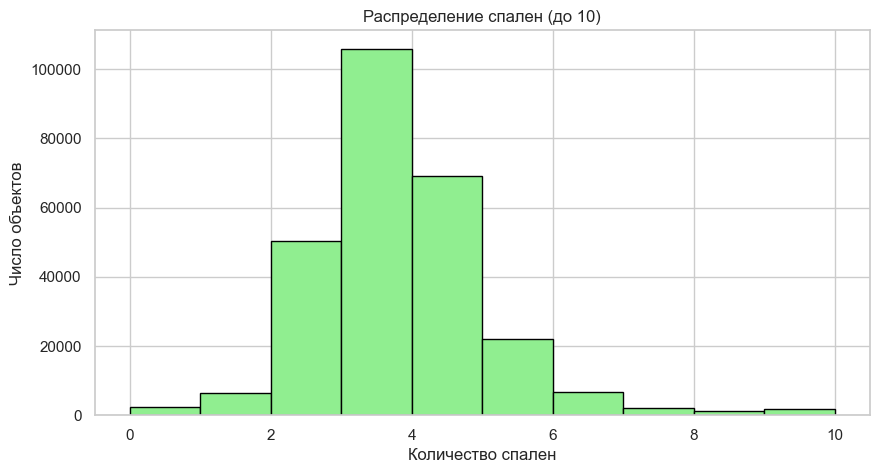

In [151]:
plt.figure(figsize=(10,5))
df[df['beds'] <= 10]['beds'].hist(bins=10, color='lightgreen', edgecolor='black')
plt.title('Распределение спален (до 10)')
plt.xlabel('Количество спален')
plt.ylabel('Число объектов')
plt.grid(True)
plt.show()


In [152]:
# Заполним пропуски beads медианой
median_beds = df['beds'].median()
df['beds'] = df['beds'].fillna(median_beds)
#
df['beds'] = df['beds'].astype(int) # превращаем в целый тип
#

### признак '**baths**'

In [153]:
df['baths'].value_counts(dropna=False).to_csv('baths.csv')
display(df['baths'].value_counts(dropna=False))

baths
NaN     107858
2.0     106811
3.0      67332
4.0      26332
1.0      22927
         ...  
25.0         1
55.0         1
14.5         1
43.0         1
68.0         1
Name: count, Length: 85, dtype: int64

Графики распределение спален  '**baths**' 

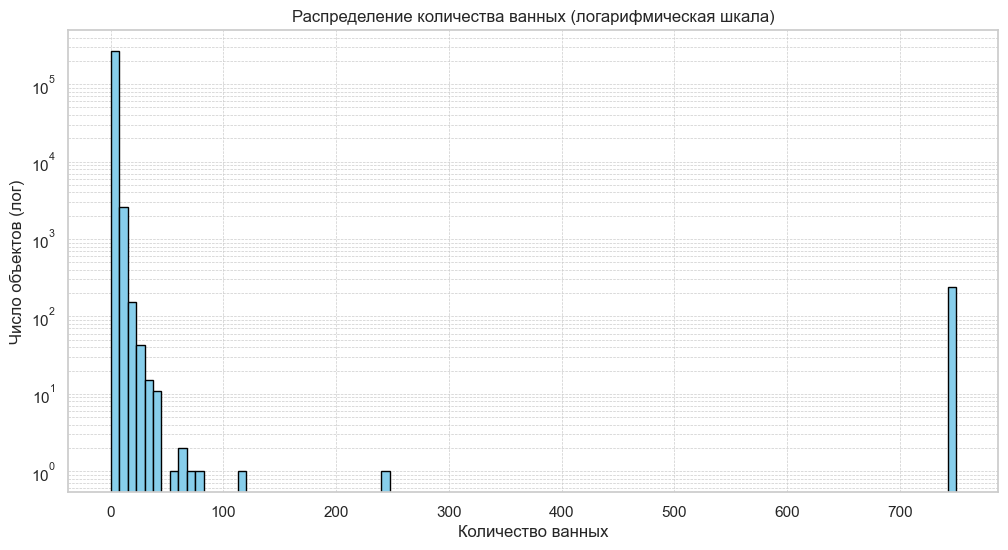

In [154]:
plt.figure(figsize=(12,6))
df['baths'].hist(bins=100, color='skyblue', edgecolor='black')
plt.yscale('log')  # 🔥 Вот эта строка делает ось Y логарифмической
plt.title('Распределение количества ванных (логарифмическая шкала)')
plt.xlabel('Количество ванных')
plt.ylabel('Число объектов (лог)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

На графике видны очевидные выбросы, больше 100 ванных комнат.Даже после 50 ванн можно считать выбросами, так как это единичные случаи
в соответствие с логарифмической шкалой по y

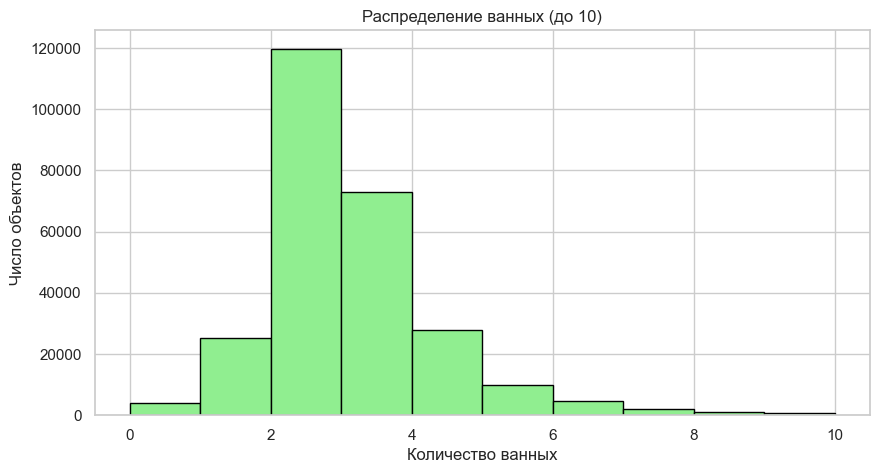

In [155]:
plt.figure(figsize=(10,5))
df[df['baths'] <= 10]['baths'].hist(bins=10, color='lightgreen', edgecolor='black')
plt.title('Распределение ванных (до 10)')
plt.xlabel('Количество ванных')
plt.ylabel('Число объектов')
plt.grid(True)
plt.show()

На этом графике видно, что реальное количество ванных комнат заканчивается на 10. Остальное можно считать выбросами.

In [156]:
# Заполним пропуски beads медианой
median_baths = df['baths'].median()
df['baths'] = df['baths'].fillna(median_baths)
#
df['baths'] = df['baths'].astype(int) # превращаем в целый тип
#
df['baths'] = np.where(df['baths'] > 10, 10, df['baths'])
#

### признак '**target**'

заполняем недостающие ~10000 пропусков с помощью **импутации**, используя bath и beds


In [157]:
#
imputer = KNNImputer()
df['target'] = imputer.fit_transform(df[['target', 'baths', 'beds']])[:, 0]

### признак '**home_Price/sqft**' - цена за квадратный метр.

In [158]:
df['home_Price/sqft'].value_counts(dropna=False).to_csv('home_Price_sqft.csv')
display(df['home_Price/sqft'].value_counts(dropna=False))

home_Price/sqft
None                58525
                     5185
No Data              1241
$1/sqft               974
No Info               954
                    ...  
$10714 / Sq. Ft.        1
$1,506                  1
$3,077/sqft             1
$2,244/sqft             1
$1,207                  1
Name: count, Length: 6506, dtype: int64

этот признак весьма замусоренный, к томуже у нас есть очищенные признаки target и sqft. Так что home_price/sqft вполне разумно удалить.

In [159]:
df = df.drop(columns=['home_Price/sqft'], errors='ignore')
#
df = df.drop(columns=['schools', 'homeFacts'], errors='ignore')



### признак '**sqft**'

In [160]:
# Фильтруем строки, где площадь равна нулю
zero_sqft = df[df['sqft'] == 0.0]

# Выбираем 20 случайных строк
sample = zero_sqft.sample(n=20, random_state=42)

# Выводим результат
##display(sample)

Мы предварительно убедились, что sqft = 0 скорее просто по ошибке и заменяем нули на NaN

теперь заполняем недостающие ~50000 пропусков с помощью **импутации**, используя признаки '**bath**' и '**beds**'

In [161]:
# Заменяем 0 на NaN в признаке 'sqft'
df['sqft'] = df['sqft'].replace(0.0, np.nan)

In [162]:
original_baths_beds = df[['baths', 'beds']].copy()
df[['baths', 'beds']] = df[['baths', 'beds']].replace(0.0, np.nan) # временно убираем нулевые baths и beds

In [ ]:
#
imputer = KNNImputer()
df['sqft'] = imputer.fit_transform(df[['sqft', 'baths', 'beds']])[:, 0]
#

In [ ]:
df[['baths', 'beds']] = original_baths_beds # возвращаем нули обратно

In [ ]:
df['sqft'].value_counts(dropna=False).to_csv('sqft.csv')
##display(df['sqft'].value_counts(dropna=False))

### признак '**home_lotsize**'  - размер земельного участка

In [ ]:
#
df['home_lotsize'].value_counts(dropna=False).head(2000).to_csv('home_lotsize_2000.csv')
##df['home_lotsize'].value_counts(dropna=False).to_csv('home_lotsize.csv')
display(df['home_lotsize'].value_counts(dropna=False))

home_lotsize
                  33055
None              28387
—                 25251
No Data            5329
-- sqft lot        3819
                  ...  
10,833 Sq. Ft.        1
9,735 sqft            1
2541                  1
5096                  1
28.40 acres           1
Name: count, Length: 37395, dtype: int64

In [ ]:
# Функция для очистки 'home_lotaize' и преобразования в sqft
def convert_to_sqft(value):
    if pd.isna(value) or str(value).strip() in ['No Data', '—', '-- sqft lot', '', ' ']:
        return None
    value = str(value).lower().replace(',', '').strip()
    
    # Если указано в sqft
    if 'sqft' in value or 'sq. ft.' in value:
        match = re.search(r'(\d*\.?\d+)', value)
        return float(match.group(1)) if match else None
    
    # Если указано в acres
    elif 'acre' in value:
        match = re.search(r'(\d*\.?\d+)', value)
        return float(match.group(1)) * 43560 if match else None
    
    # Если просто число
    elif value.isdigit():
        return float(value)
    
    return None

# Применение функции
df['lotsize_sqft'] = df['home_lotsize'].apply(convert_to_sqft)
#
# Сохранение результата
df.to_csv('home_lotsize_2000_cleaned.csv', index=False)


Заполняем недостающие площади земельных участков как медианные по признаку '**zipcode**', а потое еще как медианные по '**city**'

In [ ]:
# Сначала по ZIP
df['lotsize_sqft_zip'] = df.groupby('zipcode')['lotsize_sqft'].transform(
    lambda x: x.fillna(x.median())
)

# Потом по city, если всё ещё NaN
df['lotsize_sqft'] = df['lotsize_sqft_zip']
df['lotsize_sqft'] = df.groupby('city')['lotsize_sqft'].transform(
    lambda x: x.fillna(x.median())
)

# Удалим временный столбец
df.drop(columns=['lotsize_sqft_zip'], inplace=True)
#
df['lotsize_sqft'].fillna(df['lotsize_sqft'].median(), inplace=True)
#
df = df.drop(columns=['home_lotsize'], errors='ignore')
#

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Asus\A

In [ ]:
df['lotsize_sqft'].value_counts(dropna=False).to_csv('lotsize_sqft.csv') # площадь стандартизирована в sqft

### признак '**city**'и '**zipcode**'

In [ ]:
df['zipcode_prefix'] = df['zipcode'].astype(str).str[:3]
#
top_cities = df['city'].value_counts().nlargest(100).index
df['city_grouped'] = df['city'].apply(lambda x: x if x in top_cities else 'Other')
#

In [ ]:
df['zipcode_prefix'].value_counts(dropna=False).to_csv('zipcode_prefix.csv')
display(df['zipcode_prefix'].value_counts(dropna=False))
#
df['city_grouped'].value_counts(dropna=False).to_csv('city_grouped.csv')
display(df['city_grouped'].value_counts(dropna=False))

zipcode_prefix
331    27060
770    24571
782    16295
333    12201
339    11449
       ...  
377        1
105        1
451        1
438        1
227        1
Name: count, Length: 388, dtype: int64

city_grouped
Other               103358
Houston              24441
San Antonio          15592
Miami                15524
Jacksonville         10015
                     ...  
Asheville              791
Port Saint Lucie       789
Panama City            777
Midland                753
Oakland                738
Name: count, Length: 101, dtype: int64

создаем новые признаки '**city_encoded**' и '**zipcode_encoded**', составящие из медианных цен по городам и почтовым индексам, так как изначально
признаки городов очень разнообразны, а признаки почтовых кодов практически все уникальны.  

In [ ]:
city_mean_price = df.groupby('city')['target'].mean()
df['city_encoded'] = df['city'].map(city_mean_price)
#
city_mean_price = df.groupby('zipcode')['target'].mean()
df['zipcode_encoded'] = df['zipcode'].map(city_mean_price)
#
# ------------ заполнение медианой пропусков в 'city_encoded'
#
df['city_encoded'] = df['city_encoded'].apply(lambda x: int(round(x)) if pd.notnull(x) else x)
#
median_value = df['city_encoded'].median()
df['city_encoded'] = df['city_encoded'].fillna(median_value)
#
df['city_encoded'].value_counts(dropna=False).to_csv('city_encoded.csv')
display(df['city_encoded'].value_counts(dropna=False))
#
df['zipcode_encoded'].value_counts(dropna=False).to_csv('zipcode_encoded.csv')
display(df['zipcode_encoded'].value_counts(dropna=False))

city_encoded
517049.0    24441
312384.0    15592
740174.0    15524
297139.0    10015
690193.0     8855
            ...  
268900.0        1
179900.0        1
35200.0         1
769000.0        1
294900.0        1
Name: count, Length: 1911, dtype: int64

zipcode_encoded
3.301626e+05    2141
7.685764e+05    1563
4.847568e+05    1488
2.933136e+05    1390
1.745933e+05    1333
                ... 
9.499000e+05       1
1.540000e+05       1
5.990000e+05       1
2.290000e+06       1
1.845000e+06       1
Name: count, Length: 4340, dtype: int64

### признак '**street**'  (удаляем, как признак с чрезмерным количеством уникальных величин)

In [ ]:
df['street'].value_counts(dropna=False).to_csv('street.csv')
display(df['street'].value_counts(dropna=False))

street
Address Not Disclosed        672
Undisclosed Address          517
(undisclosed Address)        391
Address Not Available        175
Unknown Address               72
                            ... 
1737 Parkview Green Cir        1
14890 Rockridge Ln             1
497 Kingswood Dr               1
202 Seacrest Beach Blvd W      1
5983 Midcrown Dr               1
Name: count, Length: 337077, dtype: int64

----------------------------------------------------------------------------------------------------------------

### признак '**home_Year built**'

In [ ]:
#
# Переименование столбца
df.rename(columns={'home_Year built': 'home_Year_built'}, inplace=True)
#
df['home_Year_built'].value_counts(dropna=False).to_csv('home_Year_built.csv')
display(df['home_Year_built'].value_counts(dropna=False))

home_Year_built
        58729
2019    32168
2006     8008
2005     7503
2007     7151
        ...  
1811        1
1845        1
1208        1
1780        1
1823        1
Name: count, Length: 232, dtype: int64

In [ ]:
# Преобразуем к числовому типу
df['home_Year_built'] = pd.to_numeric(df['home_Year_built'], errors='coerce')
#
# Удалим явно ошибочные значения
#
df.loc[(df['home_Year_built'] < 1800) | (df['home_Year_built'] > 2025), 'home_Year_built'] = np.nan
#


заполняем пропуски home_Year_built через импутацию, используя zip и city


In [ ]:
# Сначала по ZIP
df['built_zip'] = df.groupby('zipcode')['home_Year_built'].transform(
    lambda x: x.fillna(x.median())
)

# Потом по city, если всё ещё NaN
df['home_Year_built'] = df['built_zip']
df['home_Year_built'] = df.groupby('city')['home_Year_built'].transform(
    lambda x: x.fillna(x.median())
)

# Удалим временный столбец
df.drop(columns=['built_zip'], inplace=True)
#
df['home_Year_built'].fillna(df['home_Year_built'].median(), inplace=True)
#
##df = df.drop(columns=['home_lotsize'], errors='ignore')
#

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Asus\A

In [ ]:
df['home_Year_built'].value_counts(dropna=False).to_csv('home_Year_built.csv')
display(df['home_Year_built'].value_counts(dropna=False))

home_Year_built
2019.0    32178
1985.0     8136
2006.0     8043
2005.0     7567
1984.0     7521
          ...  
1809.0        1
1805.0        1
1843.0        1
1808.0        1
1804.0        1
Name: count, Length: 278, dtype: int64


### признак '**home_Remodeled year**'

In [ ]:
# Переименование столбца
df.rename(columns={'home_Remodeled year': 'home_Remodeled_year'}, inplace=True)

In [ ]:
df['home_Remodeled_year'].value_counts(dropna=False).to_csv('home_Remodeled_year.csv')
display(df['home_Remodeled_year'].value_counts(dropna=False))

home_Remodeled_year
        199495
None     26567
2006      5538
2005      4817
2007      4387
         ...  
1738         1
1845         1
1846         1
1862         1
1111         1
Name: count, Length: 156, dtype: int64

In [ ]:
# Преобразуем к числовому типу
df['home_Remodeled_year'] = pd.to_numeric(df['home_Remodeled_year'], errors='coerce')

# Удалим явно ошибочные значения
df.loc[df['home_Remodeled_year'] == 1111, 'home_Remodeled_year'] = np.nan

# есть 'home_Year_built', можно заполнить пропуски
df['home_Remodeled_year'].fillna(df['home_Year_built'], inplace=True)
#
current_year = 2025  # или взять из данных
df['age_since_remodel'] = current_year - df['home_Remodeled_year']  # новый признак на основе ome_Remodeled_year
#
##df = df.drop(columns=['home_Remodeled_year'], errors='ignore')
#

C:\Users\Asus\AppData\Local\Temp\ipykernel_4960\175016536.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['home_Remodeled_year'].fillna(df['home_Year_built'], inplace=True)


In [ ]:
df = df.drop(columns=['home_Remodeled_year'], errors='ignore')

### признаки  '**home_Heating**'   '**home_Cooling**'   '**home_Parking**'

In [ ]:
df['home_Heating'].value_counts(dropna=False).to_csv('home_Heating.csv')
display(df['home_Heating'].value_counts(dropna=False))
#
df['home_Cooling'].value_counts(dropna=False).to_csv('home_Cooling.csv')
display(df['home_Heating'].value_counts(dropna=False))
#
df['home_Parking'].value_counts(dropna=False).to_csv('home_Parking.csv')
display(df['home_Heating'].value_counts(dropna=False))

home_Heating
                                                                            105760
Forced Air                                                                   82804
Forced air                                                                   51504
Other                                                                        29622
Electric                                                                     10210
                                                                             ...  
Gas, Solar                                                                       1
Forced Air, 2 or more H20 Heaters                                                1
Central Gas, Propane, Win/Wall Unit                                              1
Central, Combination                                                             1
90% Forced Air Heating, Central Heating, Programmable Thermostat Heating         1
Name: count, Length: 1986, dtype: int64

home_Heating
                                                                            105760
Forced Air                                                                   82804
Forced air                                                                   51504
Other                                                                        29622
Electric                                                                     10210
                                                                             ...  
Gas, Solar                                                                       1
Forced Air, 2 or more H20 Heaters                                                1
Central Gas, Propane, Win/Wall Unit                                              1
Central, Combination                                                             1
90% Forced Air Heating, Central Heating, Programmable Thermostat Heating         1
Name: count, Length: 1986, dtype: int64

home_Heating
                                                                            105760
Forced Air                                                                   82804
Forced air                                                                   51504
Other                                                                        29622
Electric                                                                     10210
                                                                             ...  
Gas, Solar                                                                       1
Forced Air, 2 or more H20 Heaters                                                1
Central Gas, Propane, Win/Wall Unit                                              1
Central, Combination                                                             1
90% Forced Air Heating, Central Heating, Programmable Thermostat Heating         1
Name: count, Length: 1986, dtype: int64

словарь для очистки признака  'home_Heating'

In [ ]:
heating_grouping_dict = {
    'forced_air': [
        'Forced Air', 'Forced air', 'Forced Air Heating', 'Forced Air - Gas',
        'Forced Air Heating, Central Heating', 'Forced Air - Propane',
        'ForcedAir', 'Forced Air 1 Zone', 'Forced Air - Oil'
    ],
    'heat_pump': [
        'Heat Pump', 'Heat pump', 'Heat Pump(s)', 'Heat Pump - Heat',
        'Heat Pump - Electric BackUp', 'Heat Pump - Gas BackUp'
    ],
    'electric': [
        'Electric', 'Electric Heat', 'Electric Hot Air', 'Electric Source',
        'Electric Heating', 'Electric Baseboard'
    ],
    'gas': [
        'Gas', 'Gas Heat', 'Natural Gas', 'Gas Hot Air/Furnace',
        'Gas - Liquid Propane Bottle', 'Gas Electric'
    ],
    'central': [
        'Central', 'Central Air', 'Central Heating', 'Central Furnace',
        'Central Cooling', 'Central Heat'
    ],
    'baseboard': [
        'Baseboard', 'Baseboard - Electric', 'Baseboard - Hot Water',
        'Baseboard Heaters'
    ],
    'radiant': [
        'Radiant', 'Radiator', 'Radiators', 'Steam', 'Hot Water/Steam',
        'Hot Water', 'Hot Air'
    ],
    'wall': [
        'Wall', 'Wall Heater', 'Wall Furnace', 'Wall/Window Unit(s)',
        'Window Units', 'Window Unit(s)', 'Wall/Window Unit'
    ],
    'other': [
        'Other', 'No Data', 'None', 'Heating System', 'Has Heating',
        'Contact manager', 'Yes', 'No Cooling/Vent'
    ]
}
def map_heating(value):
    for group, keywords in heating_grouping_dict.items():
        if any(k.lower() in str(value).lower() for k in keywords):
            return group
    return 'other'

df['heating_group'] = df['home_Heating'].apply(map_heating)


In [ ]:
df['heating_group'].value_counts(dropna=False).to_csv('heating_group.csv')
display(df['heating_group'].value_counts(dropna=False))
#

heating_group
other         152612
forced_air    140919
electric       27882
central        18703
gas            15199
heat_pump      11441
baseboard       4192
wall            4101
radiant         2136
Name: count, dtype: int64

словарь, для очистки и систематизации признака 'home_Cooling'

In [ ]:
cooling_grouping_dict = {
    'central': [
        'Central', 'Central Air', 'Central A/C', 'Central Cooling',
        'Central AC', 'Central Air Conditioning', 'Central Electric',
        'Central Gas', 'Central Heating', 'Central A/C (Electric)',
        'Central A/C (Gas)', 'Central Air - Electric', 'Central Air - Gas',
        'Central Air - Zoned', 'Central Air, Zoned', 'Central Air, Multizone A/C'
    ],
    'evaporative': [
        'Evaporative', 'Evaporative Cooler (Swamp)', 'Evaporative Cooling',
        'Evaporative, Wall', 'Evaporative, Solar'
    ],
    'heat_pump': [
        'Heat Pump', 'Heat Pump - AC', 'Heat Pump(Cooling)',
        'Heat Pump for A/C', 'Heat Pump for Heat', 'Heat Pump, Zoned',
        'Heat Pump Heating'
    ],
    'electric': [
        'Electric', 'Electric Heating', 'Electric Hot Air',
        'Electric Heat', 'Electric Cooling', 'Electric Baseboard Heat'
    ],
    'gas': [
        'Gas Heating', 'Gas Hot Air/Furnace', 'Gas (Hot Air)',
        'Natural Gas Heat', 'Gas', 'Gas (Water Heater)'
    ],
    'wall_window': [
        'Wall', 'Wall/Window Unit(s)', 'Wall Unit(s)', 'Wall Unit',
        'Window Unit(s)', 'Window Unit', 'Window Units', 'Wall or Window Units',
        'Window', 'Window AC', 'Window A/C', 'Wall AC Units'
    ],
    'none': [
        'None', 'No Data', 'No Cooling/Vent', 'No Air Conditioning',
        'No A/C', 'No Heat', 'No Heating'
    ],
    'other': [
        'Other', 'Other Cooling', 'Other Heating', 'Other Heating Fuel (See Remarks)',
        'Contact manager', 'Cooling System', 'Has Cooling', 'Has Heating'
    ]
}
def map_cooling(value):
    for group, keywords in cooling_grouping_dict.items():
        if any(k.lower() in str(value).lower() for k in keywords):
            return group
    return 'other'

df['cooling_group'] = df['home_Cooling'].apply(map_cooling)
#

In [ ]:
df['cooling_group'].value_counts(dropna=False).to_csv('cooling_group.csv')
display(df['cooling_group'].value_counts(dropna=False))

cooling_group
central        204535
other          140392
none            21753
wall_window      5463
electric         1546
heat_pump        1274
evaporative      1223
gas               999
Name: count, dtype: int64

словарь для очистки признака 'home_Parking'

In [ ]:
parking_grouping_dict = {
    'attached_garage': [
        'Attached Garage', 'Garage-Attached', 'Garage Attached',
        'Attached - FRONT', 'Attached - SIDE', 'Attached - REAR',
        'Attached', 'Garage Attached', 'Attached Garage, Garage - 2 Car'
    ],
    'detached_garage': [
        'Detached Garage', 'Garage-Detached', 'Detached',
        'Detached parking', 'Garage Detached'
    ],
    'carport': [
        'Carport', 'Carport Spaces', 'Carport - 1 Car', 'Carport - 2 Car',
        'Attached Carport', 'Detached Carport', 'Carport-Attached', 'Carport-Detached'
    ],
    'driveway': [
        'Driveway', 'Driveway Paved', 'Driveway Only', 'Driveway Unpaved',
        'Driveway Description', 'Driveway Spaces', 'Driveway Gate',
        'Driveway - Concrete', 'Driveway - Pavers'
    ],
    'off_street': [
        'Off Street', 'Off street', 'Off Street Parking', 'Off street parking',
        'Off Street, Attached Garage', 'Off Street, Detached Garage'
    ],
    'on_street': [
        'On Street', 'On street', 'On-Street Parking', 'On Street Parking'
    ],
    'garage': [
        'Garage', 'Garage - 1 Car', 'Garage - 2 Car', 'Garage - 3 Car',
        'Garage - 4+ Car', 'Garage Lot', 'Garage Parking Description'
    ],
    'assigned': [
        'Assigned', 'Assigned Parking', 'Assigned Parking Space - 1',
        'Assigned Parking Space - 2', 'Assigned Parking Space'
    ],
    'none': [
        'None', 'No Data', 'No Garage', 'No Parking', 'No'
    ],
    'mixed': [
        'Attached Garage, Detached Garage', 'Carport, Attached Garage',
        'Attached Garage, Carport', 'Detached Garage, Carport',
        'Carport, Detached Garage', 'Attached Garage, Driveway',
        'Attached Garage, Off Street', 'Off Street, On Street',
        'Attached Garage, Detached Garage, Carport'
    ],
    'parking_space': [
        'Parking Desc', 'Parking Type', 'ParkingType', 'Parking Features',
        'Garage Type', 'Parking Lot', 'Parking Space', 'Parking Under Building',
        'Parking Driveway', 'Parking Space - 1', 'Parking Space - 2',
        'Parking Space - 3', 'Parking Space - 4+', 'Parking Space - 4+',
        'Parking', 'Parking Garage', 'Parking Pad', 'Parking Fee'
  ]
}
def map_parking(value):
    for group, keywords in parking_grouping_dict.items():
        if any(k.lower() in str(value).lower() for k in keywords):
            return group
    return 'other'

df['parking_group'] = df['home_Parking'].apply(map_parking)

In [ ]:
df['parking_group'].value_counts(dropna=False).to_csv('parking_group.csv')
display(df['parking_group'].value_counts(dropna=False))

parking_group
other              234173
attached_garage     82723
none                19328
detached_garage     14979
carport              8614
off_street           6697
parking_space        3056
garage               2622
driveway             2482
on_street            1917
assigned              594
Name: count, dtype: int64

In [ ]:
df = df.drop(columns=['home_Heating', 'home_Cooling', 'home_Parking'], errors='ignore')


In [ ]:
df_1 = df.copy()

###  признаки  '**school_names**', '**school_ratings**', '**school_distances**', '**school_grades**'

In [ ]:
df['school_names'].value_counts(dropna=False).to_csv('school_names.csv')
display(df['school_names'].value_counts(dropna=False))

school_names
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 4284
Air Base Elementary School, Booker T. Washington Senior High School                                                                                                                                                                                                                                                                                  

In [ ]:
df.drop(columns=['school_names'], inplace=True)  # удаляем имена школ, как очень шумный, так как там бесконечное число уникальных значений.


In [ ]:
df['school_ratings'].value_counts(dropna=False).to_csv('school_ratings.csv')
display(df['school_ratings'].value_counts(dropna=False))

school_ratings
                               4284
10/10, 2/10                    3407
10/10, 4/10, 5/10              2061
10/10, 5/10                    1927
3/10, 3/10, 4/10               1808
                               ... 
6, 6, 2, 4, 5, NR, NR, NR         1
6, 3, 4, 7, 5, NR, NR, 4, 1       1
6, 5, 4, 8, 4, NR, NR, NR         1
4, 3, 3, 4, 3, 1, 3, 1, 2         1
8, 5, 3, 3, 1, 1, 3, 2, 1         1
Name: count, Length: 17179, dtype: int64

In [ ]:
#
# Чтение исходного файла
df_ratings = pd.read_csv('school_ratings.csv')

# Сохранение первых 200 строк
df_ratings.head(200).to_csv('school_ratings_sample.csv', index=False)


очистка признака 'school_ratings'

In [ ]:

# Функция очистки строки
def clean_ratings(rating_str):
    if pd.isna(rating_str):
        return ''
    # Найти все числа перед "/10" или одиночные числа
    numbers = re.findall(r'\b\d+(?=/10)|\b\d+\b', rating_str)
    return ','.join(numbers)

# Применение очистки
df['cleaned_ratings'] = df['school_ratings'].apply(clean_ratings)

# Сохранение результата
df['cleaned_ratings'].to_csv('school_ratings_cleaned.csv', index=False)
##df['cleaned_ratings'].head(200).to_csv('school_ratings_clean_200.csv', index=False)


In [ ]:
# Загружаем данные
df_1_1 = pd.read_csv("school_ratings_cleaned.csv")

# Функция для обработки строки
def process_rating_string(rating_str):
    if pd.isna(rating_str) or rating_str.strip() == '':
        return None  # временно оставим NaN
    try:
        numbers = [int(x) for x in rating_str.split(',') if x.strip().isdigit()]
        return sum(numbers) / len(numbers) if numbers else None
    except:
        return None

# Применяем функцию
df_1_1['rating_mean'] = df_1_1['cleaned_ratings'].apply(process_rating_string)

# Вычисляем медиану по рассчитанным значениям
median_rating = df_1_1['rating_mean'].median()

# Заполняем пропуски медианой
df_1_1['rating_mean'] = df_1_1['rating_mean'].fillna(median_rating)

# Сохраняем результат
df_1_1.to_csv("school_ratings_processed.csv", index=False)

print(f"✅ Готово! Пропуски заменены на медиану: {median_rating:.2f}")


✅ Готово! Пропуски заменены на медиану: 7.00


In [ ]:
#
# Читаем файл с обработанными рейтингами
processed_df = pd.read_csv("school_ratings_processed.csv")
#
# Добавляем новый признак в df
df['school_rating_mean'] = processed_df['rating_mean']
#
df['school_rating_mean'] = df['school_rating_mean'].round(1)
# Проверим результат
print(df[['cleaned_ratings', 'school_rating_mean']].head(20))


         cleaned_ratings  school_rating_mean
0              4,4,7,4,7                 5.2
1           4,10,10,4,10                 7.6
2         8,10,4,10,8,10                 8.3
3   9,10,9,10,10,10,9,10                 9.6
4         4,10,5,10,5,10                 7.3
5                                        7.0
6                  3,3,1                 2.3
7                  4,2,2                 2.7
8              2,2,4,7,4                 3.8
9         4,10,3,10,2,10                 6.5
10       2,10,8,10,10,10                 8.3
11             6,3,6,1,5                 4.2
12        8,10,7,10,7,10                 8.7
13        7,10,7,10,8,10                 8.7
14        4,10,5,10,7,10                 7.7
15                 8,8,3                 6.3
16                   4,3                 3.5
17               2,5,1,2                 2.5
18             7,10,7,10                 8.5
19        3,10,7,10,5,10                 7.5


In [ ]:
df = df.drop(columns=['school_names','school_ratings','street','cleaned_ratings'], errors='ignore')

### признаки '**school_distances**', '**school_grades**'

In [ ]:
df['school_grades'].value_counts(dropna=False).to_csv('school_grades.csv')
display(df['school_grades'].value_counts(dropna=False))
#
df['school_distances'].value_counts(dropna=False).to_csv('school_distances.csv')
display(df['school_distances'].value_counts(dropna=False))
#

school_grades
PK-5, 6-8, 9-12                                                                                                       50884
Preschool to 5, 6 to 8, 9 to 12                                                                                       24157
K-5, 6-8, 9-12                                                                                                        16411
9-12, 6-8, PK-5                                                                                                       12678
PK-8, 9-12                                                                                                            11706
                                                                                                                      ...  
PK–6, 7–8, 9–12, PK–6, 6–12, 7–12, 6–12, PK–12                                                                            1
PK–5, 6–8, 9–12, PK–5, 5–7, 9–12, PK–6, 9–12                                                                          

school_distances
                                                                                                                                                                                    4284
NaN                                                                                                                                                                                  331
39.69mi, 39.69mi, 39.69mi                                                                                                                                                            222
3.62mi, 3.62mi, 3.62mi                                                                                                                                                               169
9.71mi, 8.92mi, 1.56mi                                                                                                                                                               133
                                                          

In [ ]:
#
# Чтение исходного файла
df_school_dist = pd.read_csv('school_distances.csv')

# Сохранение первых 200 строк
##df_school_dist.head(200).to_csv('school_dist_200.csv', index=False)


очистка признака '**school_distance**'

In [ ]:
#
# Загружаем файл
df_1_2 = df['school_distances']

# Функция для обработки строки расстояний
def extract_min_distance(dist_str):
    if pd.isna(dist_str) or dist_str.strip() == '':
        return 100.0  # если пропуск — ставим 100
    try:
        # Удаляем 'mi' и извлекаем все числа
        numbers = re.findall(r'\d+\.?\d*', dist_str.replace('mi', ''))
        numbers = [float(n) for n in numbers]
        return min(numbers) if numbers else 100.0
    except:
        return 100.0

# Применяем функцию к столбцу
df_1_2['school_min_dist'] = df_1_2.apply(extract_min_distance)

# Сохраняем результат
df_1_2['school_min_dist'].to_csv("school_dist_processed.csv", index=False)
print("✅ Готово! Минимальные расстояния сохранены в 'school_min_dist'")
#
##df_1_2 = df1['school_distances']
##df_1_2_processed = df_1_2.apply(extract_min_distance)



C:\Users\Asus\AppData\Local\Temp\ipykernel_4960\635873946.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1_2['school_min_dist'] = df_1_2.apply(extract_min_distance)


✅ Готово! Минимальные расстояния сохранены в 'school_min_dist'


In [ ]:
#
# Читаем файл с обработанными расстояниями
processed_df = pd.read_csv("school_dist_processed.csv")
#
# Добавляем новый признак в df
df['school_min_dist'] = processed_df['school_distances']
#
# Проверим результат
print(df[['school_distances', 'school_min_dist']].head(20))


                                     school_distances  school_min_dist
0   2.7 mi, 3.6 mi, 5.1 mi, 4.0 mi, 10.5 mi, 12.6 ...             2.70
1                              1.65mi, 1.32mi, 1.01mi             1.01
2                              1.19mi, 2.06mi, 2.63mi             1.19
3                       1.05mi, 0.1mi, 1.05mi, 0.81mi             0.10
4                              5.96mi, 3.25mi, 3.03mi             3.03
5                                                               100.00
6                      0.8 mi, 8.3 mi, 4.2 mi, 2.0 mi             0.80
7                              0.7 mi, 0.4 mi, 2.2 mi             0.40
8      5.6 mi, 5.6 mi, 6.8 mi, 6.5 mi, 6.8 mi, 6.8 mi             5.60
9                              0.7 mi, 0.6 mi, 1.9 mi             0.60
10                              0.3mi, 1.88mi, 2.37mi             0.30
11             0.4 mi, 0.4 mi, 3.0 mi, 3.2 mi, 7.4 mi             0.40
12                             2.66mi, 0.92mi, 2.54mi             0.92
13    

In [ ]:
count_100 = (df['school_min_dist'] == 100).sum()
print(f"Количество расстояний, равных 100: {count_100}")
#
# Выбираем значения расстояний, исключая 100
valid_distances = df[df["school_min_dist"] != 100]["school_min_dist"]
median_distance = valid_distances.median()

# Замена значений 100 на медиану
df["school_min_dist"] = df["school_min_dist"].replace(100, median_distance)


Количество расстояний, равных 100: 4615


In [ ]:
df['school_min_dist'].value_counts(dropna=False).to_csv('school_min_dist.csv')
display(df['school_min_dist'].value_counts(dropna=False))


school_min_dist
0.30     22468
0.40     20952
0.20     20260
0.50     18780
0.60     16057
         ...  
13.55        1
23.62        1
12.12        1
11.37        1
10.13        1
Name: count, Length: 1474, dtype: int64

In [ ]:
df = df.drop(columns=['school_distances', 'school_grades'], errors='ignore')


### признак '**state**'

In [ ]:
df['state'].value_counts(dropna=False).to_csv('state.csv')
display(df['state'].value_counts(dropna=False))


state
FL     115434
TX      83780
NY      24474
CA      23385
NC      21854
TN      18339
WA      13820
OH      12587
IL       8938
NV       8482
GA       6701
CO       6404
PA       5561
MI       5161
DC       4673
AZ       3347
IN       3327
OR       2789
MA       1516
UT       1325
MD       1090
VT        868
MO        866
VA        801
WI        452
NJ        436
ME        259
IA        242
KY         90
NaN        50
OK         49
MS         40
SC         28
MT          7
DE          5
Fl          1
BA          1
AL          1
OT          1
OS          1
Name: count, dtype: int64

заполняем пропуски в штатах на самый популярный FL

In [ ]:
df['state'] = df['state'].fillna('FL')

C:\Users\Asus\AppData\Local\Temp\ipykernel_4960\3841240273.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_counts.index, y=state_counts.values, palette="viridis")


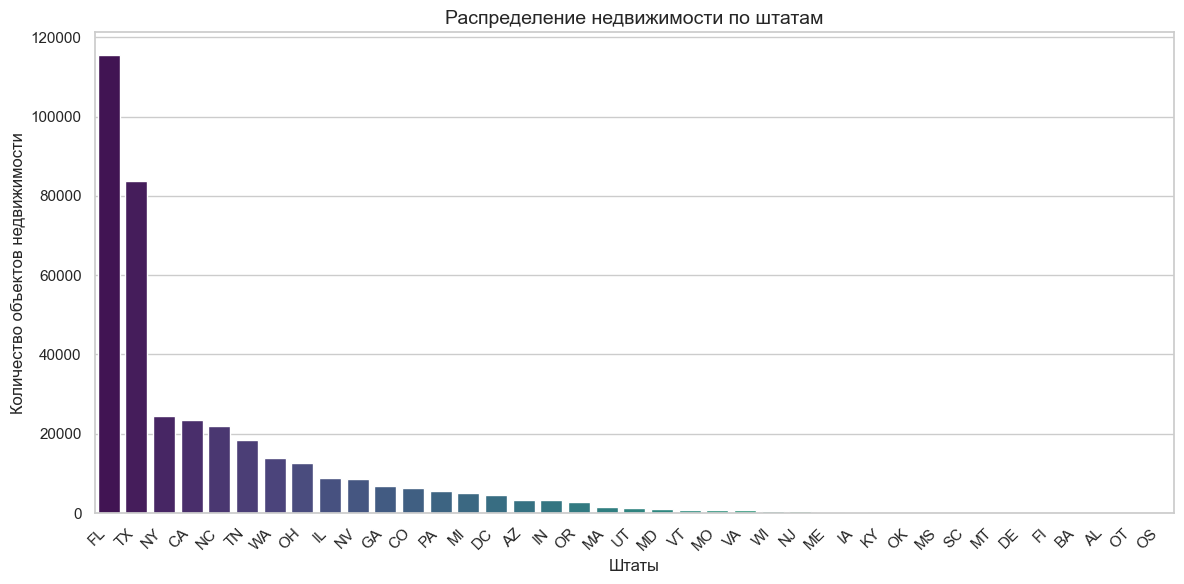

График успешно сохранен в файл state_distribution_barplot.png


In [ ]:

# Установка стиля визуализации
sns.set(style="whitegrid")
# Проверка наличия нужного столбца
if 'state' not in df.columns:
    raise ValueError("В файле отсутствует столбец 'state'.")

# Подсчет количества объектов недвижимости по штатам
state_counts = df['state'].value_counts().sort_values(ascending=False)

# Построение столбчатой диаграммы
plt.figure(figsize=(12, 6))
sns.barplot(x=state_counts.index, y=state_counts.values, palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Штаты", fontsize=12)
plt.ylabel("Количество объектов недвижимости", fontsize=12)
plt.title("Распределение недвижимости по штатам", fontsize=14)
plt.tight_layout()

# Сохранение графика
output_path = "/mnt/data/state_distribution_barplot.png"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path)
plt.show()
plt.close()

print("График успешно сохранен в файл state_distribution_barplot.png")


Количество потенциальных сдело с недвижимостью в штатах FL (Флорида) и TX (Техас) значительно привосходят все другие штаты.

C:\Users\Asus\AppData\Local\Temp\ipykernel_4960\510604574.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='state', y='target', data=median_prices, palette='viridis')


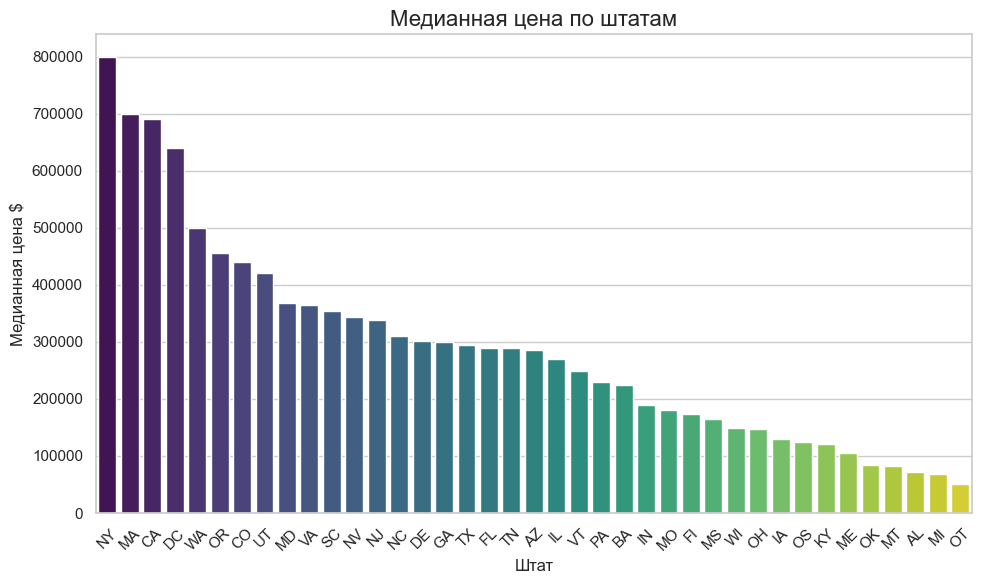

In [ ]:
#
# Set seaborn style
sns.set(style="whitegrid")

# Sample data creation for demonstration (replace with actual df if available)
##data = {
##    'state': ['CA', 'CA', 'TX', 'TX', 'NY', 'NY', 'FL', 'FL', 'FL'],
##    'price': [350000, 420000, 250000, 270000, 500000, 520000, 300000, 310000, 320000]
##}
##df = pd.DataFrame(data)
#
# Calculate median price per state
median_prices = df.groupby('state')['target'].median().reset_index()

# Sort by median price for better visualization
median_prices = median_prices.sort_values(by='target', ascending=False)

# Create output directory if it doesn't exist
output_dir = '/mnt/data'
os.makedirs(output_dir, exist_ok=True)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='state', y='target', data=median_prices, palette='viridis')
plt.title('Медианная цена по штатам', fontsize=16)
plt.xlabel('Штат', fontsize=12)
plt.ylabel('Медианная цена $', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Save plot
plot_path = os.path.join(output_dir, 'median_price_by_state.png')
plt.savefig(plot_path)
plt.show()
plt.close()

По цене лидирует штат Нью-Йорк, штаты, кде больше всего продаж (FL, TX) по цене в недорогом сегменте. Возможно там строительный бум и миграция в эти штаты.

In [ ]:
median_prices.value_counts(dropna=False).to_csv('state_median_price.csv')
display(median_prices.value_counts(dropna=False))

state  target  
AL     72000.0     1
OT     50000.0     1
NJ     339000.0    1
NV     343690.0    1
NY     799000.0    1
OH     147000.0    1
OK     85000.0     1
OR     454900.0    1
OS     125000.0    1
PA     229900.0    1
MT     82900.0     1
SC     354495.0    1
TN     289000.0    1
TX     294999.0    1
UT     419900.0    1
VA     364900.0    1
VT     249000.0    1
WA     499000.0    1
NC     309765.0    1
MS     165000.0    1
AZ     285000.0    1
GA     300000.0    1
BA     225000.0    1
CA     690990.0    1
CO     439900.0    1
DC     639990.0    1
DE     301300.0    1
FL     289900.0    1
Fl     174000.0    1
IA     129900.0    1
MO     179900.0    1
IL     269994.5    1
IN     190000.0    1
KY     121450.0    1
MA     699250.0    1
MD     367697.0    1
ME     105750.0    1
MI     69000.0     1
WI     149450.0    1
Name: count, dtype: int64

In [ ]:
df = df.drop(columns=['city', 'zipcode'], errors='ignore')

### ---------------------------    второй проход по признакам

Заполняем оставшиеся пропуски '**propertyType**' на '**single family**', как на самый популярный признак

In [ ]:
df['propertyType'] = df['propertyType'].fillna('single family')


Заполняем оставшиеся пропуски '**fireplace_count**' на 0, как на самый популярное значений

In [ ]:
df['fireplace_count'] = df['fireplace_count'].fillna(0.0)
df['fireplace_count'] = df['fireplace_count'].astype(int) # превращаем в целый тип



также заменяет оставшееся небольшое количество пропусков '**status_clean**','**zipcode_encoded**','**stories_clean**'

In [ ]:
df['status_clean'] = df['status_clean'].fillna('for sale')
#

In [ ]:
median_zipcode = df['zipcode_encoded'].median()
df['zipcode_encoded'] = df['zipcode_encoded'].fillna(median_zipcode)
df['zipcode_encoded'] = df['zipcode_encoded'].round(0).astype(int)

In [ ]:
df['stories_clean'] = df['stories_clean'].fillna('1 story')


In [ ]:
# сортируем по количеству пропусков
#
missing_info = []
#
for col in df.columns:
    non_nulls = df[col].notna().sum()
    nulls = df[col].isna().sum()
    dtype = str(df[col].dtype)
    missing_info.append((col, dtype, non_nulls, nulls))

# Сортируем по количеству пропусков
missing_info.sort(key=lambda x: x[3], reverse=True)

for col, dtype, non_nulls, nulls in missing_info:
    print(f"{col:25} | dtype: {dtype:<10} | non-null: {non_nulls:<8} | nulls: {nulls}")

fireplace                 | dtype: object     | non-null: 103111   | nulls: 274074
has_pool                  | dtype: float64    | non-null: 377135   | nulls: 50
baths                     | dtype: int32      | non-null: 377185   | nulls: 0
sqft                      | dtype: float64    | non-null: 377185   | nulls: 0
beds                      | dtype: int32      | non-null: 377185   | nulls: 0
state                     | dtype: object     | non-null: 377185   | nulls: 0
target                    | dtype: float64    | non-null: 377185   | nulls: 0
propertyType              | dtype: object     | non-null: 377185   | nulls: 0
fireplace_count           | dtype: int32      | non-null: 377185   | nulls: 0
status_clean              | dtype: object     | non-null: 377185   | nulls: 0
stories_clean             | dtype: object     | non-null: 377185   | nulls: 0
home_Year_built           | dtype: float64    | non-null: 377185   | nulls: 0
lotsize_sqft              | dtype: float64    | non-null: 

в результате работы над всеми признаками получили чистый dataframe без пропусков, в котором сохранили пока исходное значение строк.

####  ---------------  выбросы

логарифмируем все что связано с target

In [ ]:
#
# Логарифмируем target
df['target_log'] = np.log1p(df['target'])  # log1p безопасен для нуля
df['zipcode_encod_log'] = np.log1p(df['zipcode_encoded'])  # log1p безопасен для нуля
df['city_encod_log'] = np.log1p(df['city_encoded'])  # log1p безопасен для нуля
#
df = df.drop(columns=['target', 'city_encoded', 'zipcode_encoded'], errors='ignore')
#


модуль для удаления выбросов от всех признаков по процентилям

In [ ]:
#
def remove_outliers_percentile(df, lower=0.01, upper=0.99):
    """
    Удаляет выбросы из числовых столбцов DataFrame мягкой фильтрацией по процентилям.
    """
    df_clean = df.copy()
    numeric_cols = df_clean.select_dtypes(include=['int64', 'float64', 'int32']).columns

    for col in numeric_cols:
        low = df_clean[col].quantile(lower)
        high = df_clean[col].quantile(upper)
        df_clean = df_clean[(df_clean[col] >= low) & (df_clean[col] <= high)]

    return df_clean
df_cleaned = remove_outliers_percentile(df, lower=0.005, upper=0.995)
print(f"Размер до удаления выбросов: {df.shape}, после: {df_cleaned.shape}")


Размер до удаления выбросов: (377185, 23), после: (350320, 23)


дополнительное удаление выбросов 

Очищаем основной датафрейм от выбросов '**target_log**' > 14.7 и  '**target_log**' < 10.8  , тоесть удаляем очень дорогую  
и очень дешевую недвижимость (в логарифмическом представлении)

In [ ]:
#
df_cleaned = df_cleaned[(df_cleaned['target_log'] <= 14.7) & (df_cleaned['target_log'] >= 10.8)]
#




вывод информации о числовых признаках до и после удаления выбросов

In [ ]:
display(df.describe())
display(df_cleaned.describe())

,baths,sqft,beds,has_pool,fireplace_count,home_Year_built,lotsize_sqft,age_since_remodel,school_rating_mean,school_min_dist,target_log,zipcode_encod_log,city_encod_log
count,377185.000000,3.771850e+05,377185.000000,377135.000000,377185.000000,377185.000000,3.771850e+05,377185.000000,377185.000000,377185.000000,377185.000000,377185.000000,377185.000000
mean,2.465066,6.285750e+03,3.239911,0.238578,0.068765,1980.262138,9.873484e+04,42.797610,6.860076,1.173342,12.657535,12.979386,13.079671
std,1.162727,1.494365e+06,1.084356,0.426215,0.323600,30.802647,7.830557e+06,60.412944,1.676516,5.318316,1.193972,0.834773,0.713212
min,0.000000,1.000000e+00,0.000000,0.000000,0.000000,1800.000000,0.000000e+00,0.000000,1.000000,0.000000,0.693147,8.006701,8.006701
25%,2.000000,1.370000e+03,3.000000,0.000000,0.000000,1962.000000,6.250000e+03,19.000000,6.000000,0.370000,12.149508,12.478501,12.651992
50%,2.000000,1.981000e+03,3.000000,0.000000,0.000000,1985.000000,8.276000e+03,38.000000,7.000000,0.690000,12.706548,12.918814,13.072038
75%,3.000000,3.005800e+03,4.000000,0.000000,0.000000,2005.000000,1.117900e+04,55.000000,8.000000,1.300000,13.287710,13.404115,13.444728
max,10.000000,7.959794e+08,10.000000,1.000000,12.000000,2025.000000,2.147484e+09,2025.000000,10.000000,1590.380000,19.088510,17.223766,17.909855


,baths,sqft,beds,has_pool,fireplace_count,home_Year_built,lotsize_sqft,age_since_remodel,school_rating_mean,school_min_dist,target_log,zipcode_encod_log,city_encod_log
count,322125.000000,322125.000000,322125.000000,322125.000000,322125.000000,322125.000000,3.221250e+05,322125.000000,322125.000000,322125.000000,322125.000000,322125.000000,322125.000000
mean,2.423885,2128.024437,3.197818,0.246817,0.065006,1981.018917,2.232124e+04,40.700554,6.871921,1.067676,12.743424,12.987550,13.083040
std,0.950454,1075.699722,0.964409,0.431160,0.273166,29.683586,7.342376e+04,27.812825,1.648234,1.218740,0.771482,0.696046,0.612256
min,0.000000,500.000000,0.000000,0.000000,0.000000,1890.000000,4.790000e+02,5.000000,2.000000,0.060000,10.800759,10.780185,11.128527
25%,2.000000,1344.000000,3.000000,0.000000,0.000000,1963.000000,6.300000e+03,19.000000,6.200000,0.380000,12.254391,12.540203,12.651992
50%,2.000000,1904.000000,3.000000,0.000000,0.000000,1985.000000,8.276000e+03,38.000000,7.000000,0.690000,12.733463,12.932166,13.072038
75%,3.000000,2800.000000,4.000000,0.000000,0.000000,2005.000000,1.089000e+04,55.000000,8.000000,1.300000,13.233907,13.360116,13.444728
max,8.000000,12628.000000,8.000000,1.000000,2.000000,2020.000000,1.252786e+06,126.000000,9.800000,10.300000,14.699469,15.531939,15.233782


в выбросы пощло довольно заметное количество строк из df (~ 50000). В итоге оперируем теперь **df_cleaned**

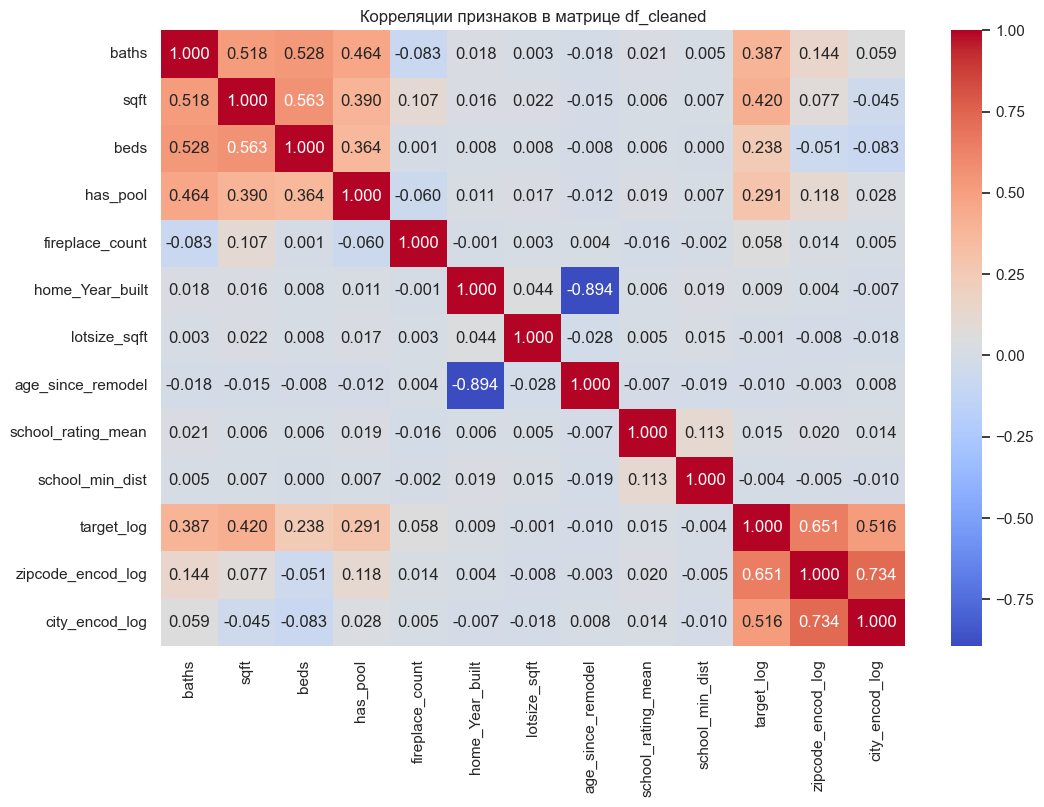

In [ ]:
#
# Корреляционная матрица
corr_matrix = df_cleaned.corr(method='spearman',numeric_only=True)

# Визуализация
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".3f")
plt.title("Корреляции признаков в матрице df_cleaned")
plt.show()


в корреляционной матрице нас интерисует корреляции логарифма цены '**target_log**'. Мы видим, что по всем числовым параметром наблюдается корреляция ( или антикорреляция)  
различной степени. Основные числовые признаки ( в порядке убывания коэффициента корреляции): '**zipcode_encoded_log**', '**city_encoded_log**', '**sqft**', '**baths**, '**has_pool**', '**beds**',  
что, вполне ощутимо закономерно.

программа кодирования нечисловых признаков

In [ ]:
#
def encode_categorical(df, target_column):
    df_encoded = df.copy()
    cat_cols = df.select_dtypes(include='object').columns

    # Разделим признаки по количеству уникальных значений
    one_hot_cols = []
    target_enc_cols = []
    label_enc_cols = []

    for col in cat_cols:
        n_unique = df[col].nunique()
        if n_unique <= 10:
            one_hot_cols.append(col)
        elif n_unique <= 50:
            target_enc_cols.append(col)
        else:
            label_enc_cols.append(col)

    print("🔹 One-Hot Encoding:", one_hot_cols)
    print("🔹 Target Encoding:", target_enc_cols)
    print("🔹 Label Encoding:", label_enc_cols)

    # Применим One-Hot Encoding
    if one_hot_cols:
        df_encoded = pd.get_dummies(df_encoded, columns=one_hot_cols, drop_first=True)

    # Применим Target Encoding
    if target_enc_cols:
        te = TargetEncoder(cols=target_enc_cols)
        df_encoded[target_enc_cols] = te.fit_transform(df_encoded[target_enc_cols], df_encoded[target_column])

    # Применим Label Encoding
    for col in label_enc_cols:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

    return df_encoded
#
#
df_encoded = encode_categorical(df_cleaned, target_column='target_log') # финальная закодированная матрица
#


🔹 One-Hot Encoding: ['propertyType', 'status_clean', 'heating_group', 'cooling_group']
🔹 Target Encoding: ['state', 'stories_clean', 'parking_group']
🔹 Label Encoding: ['fireplace', 'zipcode_prefix', 'city_grouped']


выводим финальный  **df_encoded** после очистки и кодирования.

In [ ]:
# сортируем по количеству пропусков
#
missing_info = []
#
for col in df_encoded.columns:
    non_nulls = df_encoded[col].notna().sum()
    nulls = df_encoded[col].isna().sum()
    dtype = str(df_encoded[col].dtype)
    missing_info.append((col, dtype, non_nulls, nulls))

# Сортируем по количеству пропусков
missing_info.sort(key=lambda x: x[3], reverse=True)

for col, dtype, non_nulls, nulls in missing_info:
    print(f"{col:25} | dtype: {dtype:<10} | non-null: {non_nulls:<8} | nulls: {nulls}")

baths                     | dtype: int32      | non-null: 322125   | nulls: 0
fireplace                 | dtype: int32      | non-null: 322125   | nulls: 0
sqft                      | dtype: float64    | non-null: 322125   | nulls: 0
beds                      | dtype: int32      | non-null: 322125   | nulls: 0
state                     | dtype: float64    | non-null: 322125   | nulls: 0
has_pool                  | dtype: float64    | non-null: 322125   | nulls: 0
fireplace_count           | dtype: int32      | non-null: 322125   | nulls: 0
stories_clean             | dtype: float64    | non-null: 322125   | nulls: 0
home_Year_built           | dtype: float64    | non-null: 322125   | nulls: 0
lotsize_sqft              | dtype: float64    | non-null: 322125   | nulls: 0
zipcode_prefix            | dtype: int32      | non-null: 322125   | nulls: 0
city_grouped              | dtype: int32      | non-null: 322125   | nulls: 0
age_since_remodel         | dtype: float64    | non-null: 322125

###  -------------------    **ML модель прогноза цены ('target')**

In [ ]:
#
X = df_encoded.drop(columns='target_log')
y = df_encoded['target_log']
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#

### **линейная регрессия**

In [ ]:
#
model = LinearRegression()
model.fit(X_train, y_train)
#

LinearRegression()

In [ ]:
#
y_pred = model.predict(X_test)
#
mae_log = mean_absolute_error(y_test, y_pred)
rmse_log = mean_squared_error(y_test, y_pred, squared=False)
#
# Переводим из логарифмической шкалы обратно в доллары
y_pred_dollars = np.expm1(y_pred)
y_test_dollars = np.expm1(y_test)
#
mae_dollars  = mean_absolute_error(y_test_dollars, y_pred_dollars)
rmse_dollars = mean_squared_error(y_test_dollars, y_pred_dollars, squared=False)
#
print(f"📈 MAE: {mean_absolute_error(y_test, y_pred):.3f} ({mae_dollars:.1f} $)")
print(f"📉 RMSE: {mean_squared_error(y_test, y_pred, squared=False):.3f} ({rmse_dollars:.1f} $)")
print(f"📊 R²: {r2_score(y_test, y_pred):.3f}")
#



📈 MAE: 0.349 (157383.4 $)
📉 RMSE: 0.479 (290132.1 $)
📊 R²: 0.617


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


простая линейная регрессия дала не очень то высокие метрики. **R2~0.62** означаем, что модель линейной регрессии объясняет 62% дисперсии тестовых данных,**MAE ~ 157000 $**
что означает среднее отклонение y_pred от y_test на всем ценовом диапазоне, что не так то плохо. **RMSE ~ 290 000 долларов** - это среднеквадратическое отклонение - оно  
закономерно существенно выше.


### автоматический подбор начальных параметров **CatBoosting**

In [ ]:
#
# Параметры для случайного перебора
#
param_dist = {
    'iterations': [300, 500, 700, 900, 1000],
    'depth': [4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.02, 0.03, 0.05, 0.07, 0.1, 0.15],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128],
    'bagging_temperature': [0, 0.5, 1, 2, 5]
}

# Инициализация модели
catboost_base = CatBoostRegressor(
    verbose=0,
    random_state=42
)

# RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=catboost_base,
    param_distributions=param_dist,
    n_iter=30,              # Кол-во случайных конфигураций
    scoring='r2',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Обучение
search.fit(X_train, y_train)

# Предсказание
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

# Метрики
print("\n✅ Лучшие параметры:", search.best_params_)
print("📈 R² на кросс-валидации:", search.best_score_)
print("📉 MAE:", mean_absolute_error(y_test, y_pred))
print("📉 RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("📊 R² на тесте:", r2_score(y_test, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits

✅ Лучшие параметры: {'learning_rate': 0.15, 'l2_leaf_reg': 3, 'iterations': 900, 'depth': 9, 'border_count': 64, 'bagging_temperature': 0.5}
📈 R² на кросс-валидации: 0.7518455551709188
📉 MAE: 0.2608692721788803
📉 RMSE: 0.3820874012830236
📊 R² на тесте: 0.7557134404240925


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


на лучших параметрах модель  **CatBoosting** показала значительное превосходство над **линейной регрессией**. Значение **R2 ~ 0.752** на кросс валидации и **R2 ~0.756** на тестовых  
значениях y_test весьма похожи, что говорит об отсутствии переобучения. Очевидно, метрики Catboosting существенно превосходят метрики линейной регрессии.

### визуализации по результатам Catboosting

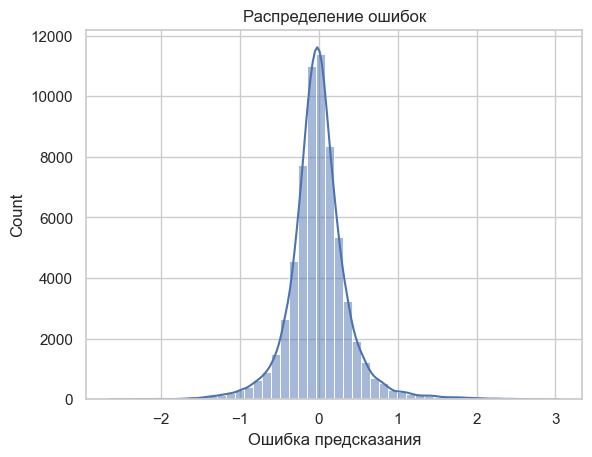

In [ ]:
#
errors = y_test - y_pred
sns.histplot(errors, bins=50, kde=True)
plt.title("Распределение ошибок")
plt.xlabel("Ошибка предсказания")
plt.show()


распределение ошибок представляет собой идеальное нормальное распределение

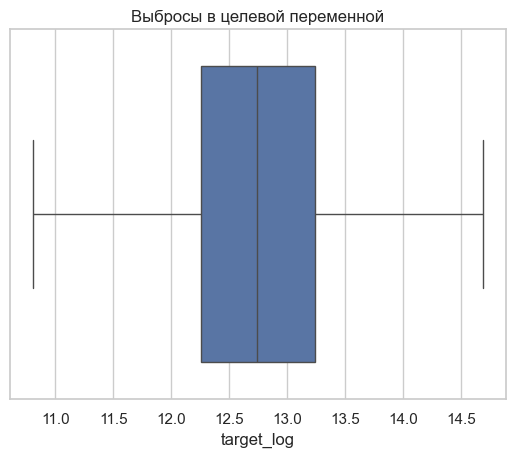

Q1 (25-й перцентиль): 12.25486757159303
Q3 (75-й перцентиль): 13.235693848424024
IQR (межквартильный размах): 0.9808262768309941
Нижний ус (левая черта): 10.803669227477098
Верхний ус (правая черта): 14.690979711984754


In [ ]:
sns.boxplot(x=y_test)
plt.title("Выбросы в целевой переменной")
plt.show()
#
# Расчёт квартилей
Q1 = y_test.quantile(0.25)
Q3 = y_test.quantile(0.75)
IQR = Q3 - Q1
#
print(f"Q1 (25-й перцентиль): {Q1}")
print(f"Q3 (75-й перцентиль): {Q3}")
print(f"IQR (межквартильный размах): {IQR}")
#
lower_whisker = y_test[y_test >= Q1 - 1.5 * IQR].min()
upper_whisker = y_test[y_test <= Q3 + 1.5 * IQR].max()

print(f"Нижний ус (левая черта): {lower_whisker}")
print(f"Верхний ус (правая черта): {upper_whisker}")


Убрали все выбросы целевой переменной target_log слева от Q1 и справа от от Q3

Графики зависимости прогнозируемой цены y_pred от реальной y_test

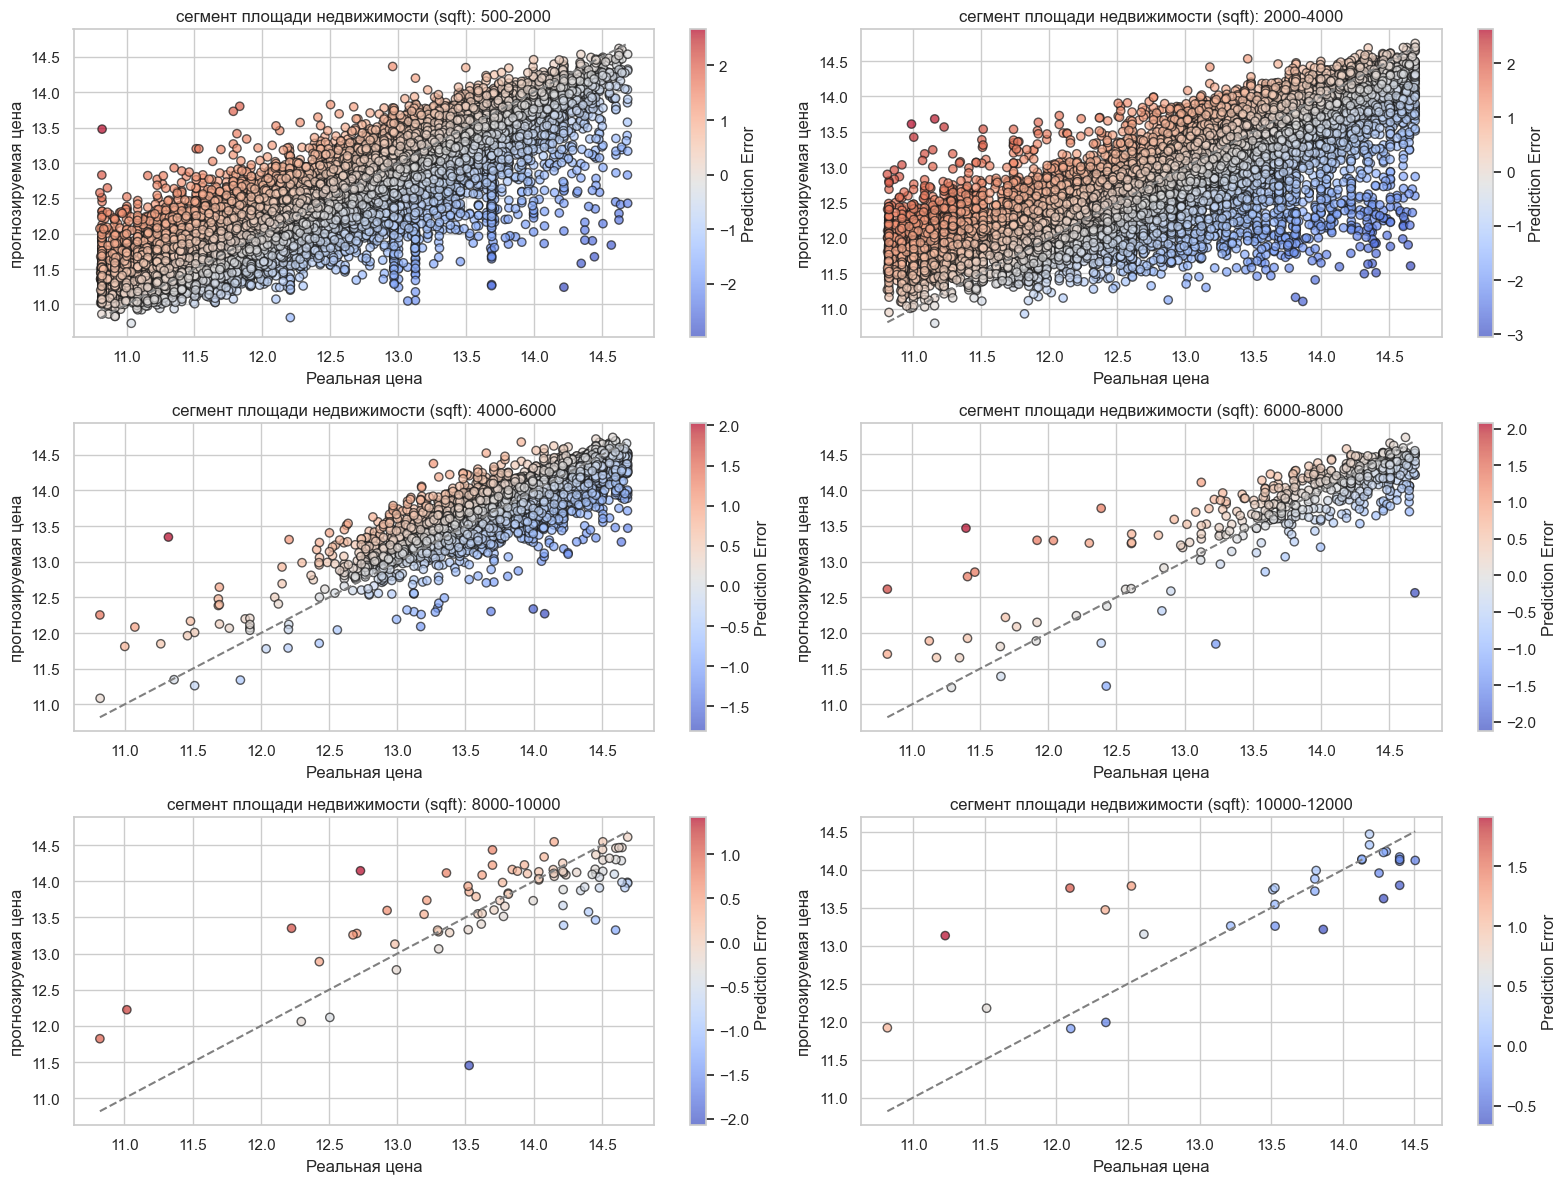

Scatter plots saved as prediction_error_scatterplots.png


In [ ]:
# Create DataFrame
##df_plot = pd.DataFrame({
##    'y_test': y_test,
##    'y_pred': y_pred,
##    'sqft': df_encoded.loc[X_test.index, 'sqft']
##})
df_plot = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred,
    'sqft': X_test['sqft'].values  # берем напрямую из X_test
})
df_plot['error'] = df_plot['y_pred'] - df_plot['y_test']
#
# Define segments based on sqft
bins = [500, 2000, 4000, 6000, 8000, 10000, 12000]
labels = ['500-2000', '2000-4000', '4000-6000', '6000-8000', '8000-10000', '10000-12000']
df_plot['segment'] = pd.cut(df_plot['sqft'], bins=bins, labels=labels)

# Set up plot style
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

# Create scatter plots for each segment
for i, segment in enumerate(labels):
    segment_data = df_plot[df_plot['segment'] == segment]
    scatter = axes[i].scatter(
        segment_data['y_test'],
        segment_data['y_pred'],
        c=segment_data['error'],
        cmap='coolwarm',
        edgecolor='k',
        alpha=0.7
    )
    axes[i].plot([segment_data['y_test'].min(), segment_data['y_test'].max()],
                 [segment_data['y_test'].min(), segment_data['y_test'].max()],
                 color='gray', linestyle='--')
    axes[i].set_title(f"сегмент площади недвижимости (sqft): {segment}")
    axes[i].set_xlabel("Реальная цена")
    axes[i].set_ylabel("прогнозируемая цена")
    fig.colorbar(scatter, ax=axes[i], label='Prediction Error')

plt.tight_layout()
os.makedirs("/mnt/data", exist_ok=True)
plt.savefig("/mnt/data/prediction_error_scatterplots.png")
plt.show()
plt.close()
print("Scatter plots saved as prediction_error_scatterplots.png")


Из приведенных графиков видно, что лучше всего моделируются случаи с площадью от 500 до 4000 футов во всем ценовом диапахоне и таких случаев подавляющее большинство. Цена недвижимости большей площади и относительно дешевой (с логарифмической ценой <12.5) предсказывается, на вид, с меньшей точностью. Однако, проверено, что таких строк в матрице df_encoded всего около 1000 и удаление их как выбросов не приводит к сколь нибуль заметным улучшением метрик. То есть случаи большой по площади и дешевой недвижимости - это особые случаи, их мало , но их не стоит считать выбросами.

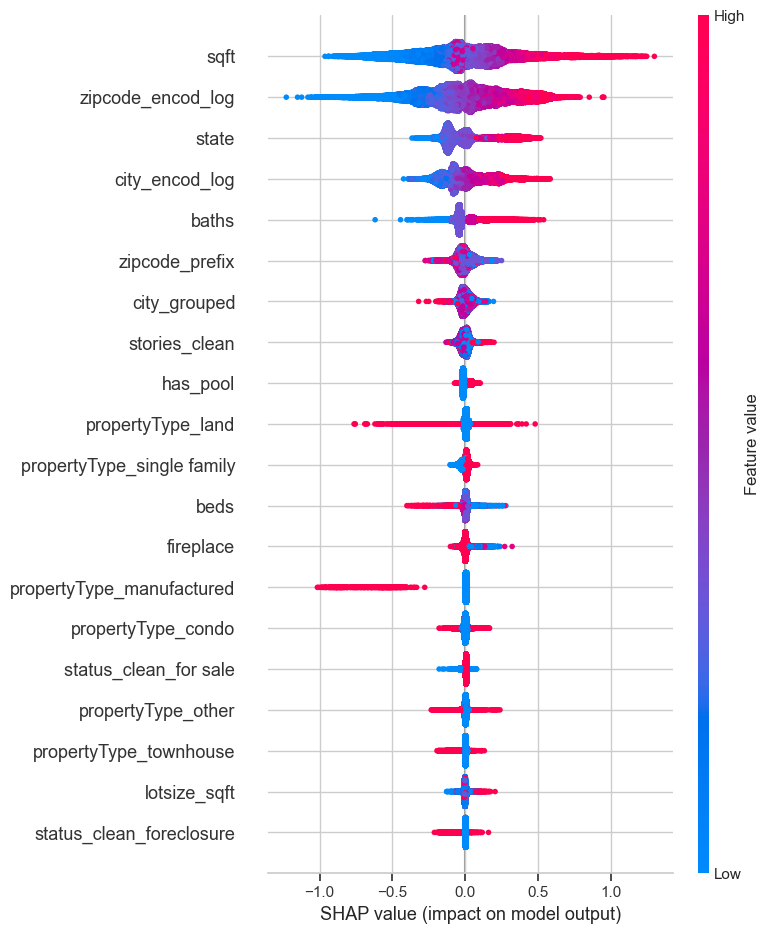

In [ ]:
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)
#
# Глобальное влияние признаков
shap.summary_plot(shap_values, X_test)
#

из графика фидно как расположены признаки (сверху вниз) по значимости влияния на целевой признак. Наше предположение о значении признаков '**zipcode_encoded_log**', '**city_encoded_log**', '**sqft**', '**baths**, '**has_pool**', '**beds**' по результатам матрицы корреляции в целом соответствуют графику. Надо понимать, что сюда вошли еще и  
закодированные категориальные признаки.

### подбор начальных параметров для **RandomForest**

ручной подбор параметров для RandomForest  ( автоматический категорически не помещался по времени)

In [ ]:
#
# Базовые параметры, которые не меняются
params_base = {
    'ccp_alpha': 0.0,
    'min_impurity_decrease': 0.0,
    'min_weight_fraction_leaf': 0.0,
    'bootstrap': True,
    'oob_score': True,
    'random_state': 42,
    'n_jobs': -1
}
#
# Варианты конфигураций 
grid = [
    {'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 0.5, 'n_estimators': 300},
    {'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.7, 'n_estimators': 400},
    {'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'n_estimators': 500},
    {'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.5, 'n_estimators': 400},
    {'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'n_estimators': 300},
    {'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 0.7, 'n_estimators': 500},
    {'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 0.7, 'n_estimators': 300},
    {'max_depth': 35, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.5, 'n_estimators': 400},
    {'max_depth': 35, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'n_estimators': 500},
    {'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.5, 'n_estimators': 500},
    {'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.7, 'n_estimators': 300},
    {'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'n_estimators': 400},
    {'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 0.5, 'n_estimators': 300},
    {'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.7, 'n_estimators': 500},
    {'max_depth': 35, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.5, 'n_estimators': 400},
]

# Перебор конфигураций и вывод метрик
for i, p in enumerate(grid, 1):
    config = {**params_base, **p}
    model = RandomForestRegressor(**config)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    print(f"\n🔧 Конфигурация {i}: {p}")
    print(f"📉 MAE: {mae:.2f}")
    print(f"📉 RMSE: {rmse:.2f}")
    print(f"📊 R²: {r2:.3f}")
    print(f"🧪 OOB R²: {model.oob_score_:.3f}")


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



🔧 Конфигурация 1: {'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 0.5, 'n_estimators': 300}
📉 MAE: 0.25
📉 RMSE: 0.38
📊 R²: 0.760
🧪 OOB R²: 0.764


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



🔧 Конфигурация 2: {'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.7, 'n_estimators': 400}
📉 MAE: 0.25
📉 RMSE: 0.38
📊 R²: 0.758
🧪 OOB R²: 0.762


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



🔧 Конфигурация 3: {'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'n_estimators': 500}
📉 MAE: 0.27
📉 RMSE: 0.39
📊 R²: 0.740
🧪 OOB R²: 0.744


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



🔧 Конфигурация 4: {'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.5, 'n_estimators': 400}
📉 MAE: 0.25
📉 RMSE: 0.38
📊 R²: 0.759
🧪 OOB R²: 0.763


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



🔧 Конфигурация 5: {'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'n_estimators': 300}
📉 MAE: 0.27
📉 RMSE: 0.39
📊 R²: 0.747
🧪 OOB R²: 0.750


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



🔧 Конфигурация 6: {'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 0.7, 'n_estimators': 500}
📉 MAE: 0.26
📉 RMSE: 0.38
📊 R²: 0.757
🧪 OOB R²: 0.761


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



🔧 Конфигурация 7: {'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 0.7, 'n_estimators': 300}
📉 MAE: 0.26
📉 RMSE: 0.38
📊 R²: 0.756
🧪 OOB R²: 0.761


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



🔧 Конфигурация 8: {'max_depth': 35, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.5, 'n_estimators': 400}
📉 MAE: 0.25
📉 RMSE: 0.38
📊 R²: 0.761
🧪 OOB R²: 0.764


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



🔧 Конфигурация 9: {'max_depth': 35, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'n_estimators': 500}
📉 MAE: 0.27
📉 RMSE: 0.39
📊 R²: 0.745
🧪 OOB R²: 0.748


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



🔧 Конфигурация 10: {'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.5, 'n_estimators': 500}
📉 MAE: 0.25
📉 RMSE: 0.38
📊 R²: 0.759
🧪 OOB R²: 0.763


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



🔧 Конфигурация 11: {'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.7, 'n_estimators': 300}
📉 MAE: 0.26
📉 RMSE: 0.38
📊 R²: 0.756
🧪 OOB R²: 0.760


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



🔧 Конфигурация 12: {'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'n_estimators': 400}
📉 MAE: 0.27
📉 RMSE: 0.39
📊 R²: 0.748
🧪 OOB R²: 0.751


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



🔧 Конфигурация 13: {'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 0.5, 'n_estimators': 300}
📉 MAE: 0.25
📉 RMSE: 0.38
📊 R²: 0.760
🧪 OOB R²: 0.764


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



🔧 Конфигурация 14: {'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.7, 'n_estimators': 500}
📉 MAE: 0.25
📉 RMSE: 0.38
📊 R²: 0.758
🧪 OOB R²: 0.762

🔧 Конфигурация 15: {'max_depth': 35, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.5, 'n_estimators': 400}
📉 MAE: 0.26
📉 RMSE: 0.38
📊 R²: 0.757
🧪 OOB R²: 0.761


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


в итоге, лучшая конфигурация оказалась под номером **8**

 ### стэкинг **СatBoostRegressor** и **RandomForest**   - обе модели с подобранными параметрами

In [ ]:
#
# 🔧 Случайный лес с лучшими параметрами
rf_model = RandomForestRegressor(
    bootstrap=True,
    ccp_alpha=0.0,
    criterion='squared_error',
    max_depth=30,
    max_features=0.5,
    max_leaf_nodes=None,
    max_samples=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=2,
    min_samples_split=5,
    min_weight_fraction_leaf=0.0,
    monotonic_cst=None,
    n_estimators=400,
    n_jobs=-1,
    oob_score=True,
    random_state=42,
    verbose=0,
    warm_start=False
)

# 🐈 CatBoost с подобранными параметрами
catboost_model = CatBoostRegressor(
    learning_rate=0.15,
    l2_leaf_reg=3,
    iterations=900,
    depth=9,
    border_count=64,
    bagging_temperature=0.5,
    verbose=0,
    random_state=42
)

# 🧠 Финальная модель (мета-модель)
meta_model = Ridge(alpha=1.0)

# 🧪 Стек
stack_model = StackingRegressor(
    estimators=[
        ('catboost', catboost_model),
        ('rf', rf_model)
    ],
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

# 🚀 Обучение
stack_model.fit(X_train, y_train)

# 📈 Предсказание
y_pred = stack_model.predict(X_test)
#

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
## 📊 Метрики стэкинга СatBoostRegressor и RandomForest
#
mae_log = mean_absolute_error(y_test, y_pred)
rmse_log = mean_squared_error(y_test, y_pred, squared=False)
#
# Переводим из логарифмической шкалы обратно в доллары
y_pred_dollars = np.expm1(y_pred)
y_test_dollars = np.expm1(y_test)
#
mae_dollars  = mean_absolute_error(y_test_dollars, y_pred_dollars)
rmse_dollars = mean_squared_error(y_test_dollars, y_pred_dollars, squared=False)
#
# 📊 Метрики
print(f"📈 MAE: {mean_absolute_error(y_test, y_pred):.3f} ({mae_dollars:.1f} $)")
print(f"📉 RMSE: {mean_squared_error(y_test, y_pred, squared=False):.3f} ({rmse_dollars:.1f} $)")
print(f"📊 R²: {r2_score(y_test, y_pred):.3f}")

📈 MAE: 0.252 (111555.4 $)
📉 RMSE: 0.375 (207489.8 $)
📊 R²: 0.765


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### сохраняем финальную модель в файл **catboost_rf_model.cbm**

In [ ]:
#
# Сохраняем модель в файл
##stack_model.save_model("catboost_rf_model.cbm")
joblib.dump(stack_model, "stack_model.pkl")


['stack_model.pkl']

### **Минимальный Flask-сервер с CatBoost**

In [ ]:
input_data = df_encoded.iloc[99].to_dict()
print(input_data)


{'baths': 5, 'fireplace': 1509, 'sqft': 4410.0, 'beds': 4, 'state': 12.636373294957043, 'has_pool': 1.0, 'fireplace_count': 0, 'stories_clean': 12.866482139946196, 'home_Year_built': 2019.0, 'lotsize_sqft': 7318.0, 'zipcode_prefix': 256, 'city_grouped': 33, 'age_since_remodel': 75.0, 'parking_group': 12.742291985849556, 'school_rating_mean': 8.8, 'school_min_dist': 0.4, 'target_log': 14.602603806532779, 'zipcode_encod_log': 13.956477860557362, 'city_encod_log': 13.15589486061312, 'propertyType_condo': False, 'propertyType_coop': False, 'propertyType_land': False, 'propertyType_luxury': False, 'propertyType_manufactured': False, 'propertyType_multi-family': False, 'propertyType_other': False, 'propertyType_single family': True, 'propertyType_townhouse': False, 'status_clean_coming soon': False, 'status_clean_contingent': False, 'status_clean_for sale': False, 'status_clean_foreclosure': False, 'status_clean_other': True, 'status_clean_pending': False, 'status_clean_rental': False, 'stat